# Explaining cortical thickness development: Prediction of modeled CT development

In [1]:
import os
from os.path import join
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from IPython.display import display

# custom functions
from scripts.templates import get_destrieux
from scripts.plots_brain import get_parc_gifti, plot_surf_ax
from scripts.utils import p_to_ast, na, rename_myelin

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# JuSpyce
sys.path.append(os.path.dirname(join(wd, "scripts", "juspyce")))
from juspyce.api import JuSpyce
from juspyce.stats import corr, residuals, mc_correction
from juspyce.plots import hide_empty_axes

# predictor data path
predictor_dir = join(wd, "data_predictors")

# centile predictions path
rutherford_dir = join(wd, "data_rutherford")

# plot directories
plot_dir_reg = join(wd, "plots", "prediction_all")
plot_dir_dom = join(wd, "plots", "prediction_dominance")
plot_dir_chart = join(wd, "plots", "braincharts")

# rerun analyses
rerun_regression = False
rerun_dominance = False
rerun_dominance_single = False

# number of permutations for all analyses
n_perm = 10000

Working directory: /Users/llotter/projects/CTdev


## Prepare cortical thickness data

### Get data

In [2]:
# load all data from juspyce file (including predictors, targets, spearman correlations)
juspyce_ct_spearman = dict(
    fm=JuSpyce.from_pickle(join(rutherford_dir, "juspyce_ct_spearman_fm.pkl.gz")),
    f=JuSpyce.from_pickle(join(rutherford_dir, "juspyce_ct_spearman_f.pkl.gz")),
    m=JuSpyce.from_pickle(join(rutherford_dir, "juspyce_ct_spearman_m.pkl.gz")))
# get target (CT) data
predicted_ct = dict(
    fm=juspyce_ct_spearman["fm"].Y,
    f=juspyce_ct_spearman["f"].Y,
    m=juspyce_ct_spearman["m"].Y)
# get predictors (factor analysis)
predictors_destrieux = juspyce_ct_spearman["fm"].X
predictors = list(predictors_destrieux.index)
# get predictors (original)
predictors_destrieux_original = \
    pd.read_csv(join(predictor_dir, 'data_parc_destrieux.csv'), index_col=0)
predictors_destrieux_original.columns = \
    [c.split("-")[1] for c in predictors_destrieux_original.columns]
predictors_destrieux_original = predictors_destrieux_original.T
# get all centiles
cent_ct = list(np.unique(predicted_ct["fm"].index.get_level_values(0)))

# parcellation
parc_destrieux, destrieux_idps = get_destrieux()

INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_spearman_fm.pkl.gz.


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_spearman_f.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_spearman_m.pkl.gz.


### IMPORTANT: Upload/Download JuSpyce results from OSF

Some of the JuSpyce output files are very large (~300MB per file, ~7.5GB overall) and thus not included in this repo (see README). This size is mostly due to the null data (10000 null maps and 10000 null analyses) being included in the files. If you want to run this notebook, you have to download all files (or only the files you are interested in) from the [OSF repo](https://osf.io/3n9rt/) and store them in /data_rutherford or uncomment and run the "DOWNLOAD" code block below (writtten for macOS). If you download only a part of the files, you will have to adapt the code in this notebook otherwise it will return errors.

In [3]:
# # UPLOAD

# ! localfiles=(data_rutherford/juspyce_ct_*.pkl.gz); \
# for f in $localfiles; \
# do; \
#     echo "Uploading" $f; \
#     osf -p 3n9rt upload -U $f $f; \
# done

In [4]:
# DOWNLOAD

# ! pip install osfclient
# ! osffiles=("${(@f)$(osf -p 3n9rt ls)}"); \
# for f in $osffiles; \
# do; \
#     f_local="data_rutherford"/$(basename $f); \
#     echo "Downloading" $f "to" $f_local; \
#     osf -p ytvkh fetch $f $f_local; \
# done

### Get CT differences

In [5]:
# time points we look at:
tps_whole = (5,30)
tps_steps = [(i,i+5) for i in np.arange(5,86,1)]
tps_index = [f"Δ({tps_whole[0]},{tps_whole[1]})"]+[f"Δ({s[0]},{s[1]})" for s in tps_steps]
print("Age-differences to look at:", tps_steps)

# alternative steps
tps_steps1 = [(i,i+1) for i in np.arange(5,90,1)]
tps_index1 = [f"Δ({tps_whole[0]},{tps_whole[1]})"]+[f"Δ({s[0]},{s[1]})" for s in tps_steps1]
tps_steps2 = [(i,i+2) for i in np.arange(5,89,1)]
tps_index2 = [f"Δ({tps_whole[0]},{tps_whole[1]})"]+[f"Δ({s[0]},{s[1]})" for s in tps_steps2]


## collect CT difference data for each centile

# data dicts for relative CT change
ct_diff = dict()
ct_diff_df = dict()
# data dicts for absolute CT change corrected for baseline CT
ct_diff_blcorr = dict()
ct_diff_blcorr_df = dict()

# iterate sexes
for sex in ["fm", "f", "m"]:
    ct_diff[sex], ct_diff_df[sex], ct_diff_blcorr[sex], ct_diff_blcorr_df[sex] = {}, {}, {}, {}
    
    # iterate timesteps defined above
    for step_len, steps, index in zip([5,1,2],
                                      [tps_steps, tps_steps1, tps_steps2],
                                      [tps_index, tps_index1, tps_index2]):
        # dict to save CT changes
        ct_diff[sex][step_len], ct_diff_blcorr[sex][step_len] = {}, {}
        
        # iterate percentiles
        for i, p in enumerate(cent_ct):
            # array to save data
            diff_data = np.zeros((len(steps)+1,predicted_ct[sex].shape[1]))
            diff_data_blcorr = diff_data.copy()
            
            # CT at T0 and T1
            ct_T0 = predicted_ct[sex].loc[(p, tps_whole[0]),:]
            ct_T1 = predicted_ct[sex].loc[(p, tps_whole[1]),:]
    
            # 0:0 relative change tps_whole
            diff_data[0,:] = (ct_T1 - ct_T0) / ct_T0
            # 0:0 absolute change, corrected for baseline
            diff_data_blcorr[0,:] = residuals(ct_T0, (ct_T1 - ct_T0))
            
            # 1:end difference tps_steps
            for i, step in enumerate(steps, start=1):
                
                # CT at T0 and T1
                ct_T0 = predicted_ct[sex].loc[(p, step[0]),:]
                ct_T1 = predicted_ct[sex].loc[(p, step[1]),:] 
                
                # relative change
                diff_data[i,:] = (ct_T1 - ct_T0) / ct_T0
                # absolute change, corrected for baseline
                diff_data_blcorr[i,:] = residuals(ct_T0, (ct_T1 - ct_T0))

            # save to dict as df
            ct_diff[sex][step_len][p] = pd.DataFrame(
                data=diff_data,
                columns=predicted_ct[sex].columns,
                index=index
            )
            ct_diff_blcorr[sex][step_len][p] = pd.DataFrame(
                data=diff_data_blcorr,
                columns=predicted_ct[sex].columns,
                index=index
            )
        
        # reshape using 2d index
        ct_diff_df[sex][step_len] = pd.concat(ct_diff[sex][step_len], axis=0) 
        ct_diff_blcorr_df[sex][step_len] = pd.concat(ct_diff_blcorr[sex][step_len], axis=0) 
        
        # print for sanity check
        print(ct_diff_df[sex][step_len].shape)
        
print(ct_diff_df["fm"][5].index)

Age-differences to look at: [(5, 10), (6, 11), (7, 12), (8, 13), (9, 14), (10, 15), (11, 16), (12, 17), (13, 18), (14, 19), (15, 20), (16, 21), (17, 22), (18, 23), (19, 24), (20, 25), (21, 26), (22, 27), (23, 28), (24, 29), (25, 30), (26, 31), (27, 32), (28, 33), (29, 34), (30, 35), (31, 36), (32, 37), (33, 38), (34, 39), (35, 40), (36, 41), (37, 42), (38, 43), (39, 44), (40, 45), (41, 46), (42, 47), (43, 48), (44, 49), (45, 50), (46, 51), (47, 52), (48, 53), (49, 54), (50, 55), (51, 56), (52, 57), (53, 58), (54, 59), (55, 60), (56, 61), (57, 62), (58, 63), (59, 64), (60, 65), (61, 66), (62, 67), (63, 68), (64, 69), (65, 70), (66, 71), (67, 72), (68, 73), (69, 74), (70, 75), (71, 76), (72, 77), (73, 78), (74, 79), (75, 80), (76, 81), (77, 82), (78, 83), (79, 84), (80, 85), (81, 86), (82, 87), (83, 88), (84, 89), (85, 90)]


(574, 148)
(602, 148)
(595, 148)
(574, 148)
(602, 148)
(595, 148)
(574, 148)
(602, 148)
(595, 148)
MultiIndex([(0.01,  'Δ(5,30)'),
            (0.01,  'Δ(5,10)'),
            (0.01,  'Δ(6,11)'),
            (0.01,  'Δ(7,12)'),
            (0.01,  'Δ(8,13)'),
            (0.01,  'Δ(9,14)'),
            (0.01, 'Δ(10,15)'),
            (0.01, 'Δ(11,16)'),
            (0.01, 'Δ(12,17)'),
            (0.01, 'Δ(13,18)'),
            ...
            (0.99, 'Δ(76,81)'),
            (0.99, 'Δ(77,82)'),
            (0.99, 'Δ(78,83)'),
            (0.99, 'Δ(79,84)'),
            (0.99, 'Δ(80,85)'),
            (0.99, 'Δ(81,86)'),
            (0.99, 'Δ(82,87)'),
            (0.99, 'Δ(83,88)'),
            (0.99, 'Δ(84,89)'),
            (0.99, 'Δ(85,90)')],
           length=574)


/Users/llotter/opt/anaconda3/envs/ntdev/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/llotter/opt/anaconda3/envs/ntdev/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Plot cortex development

#### Plot heatmap

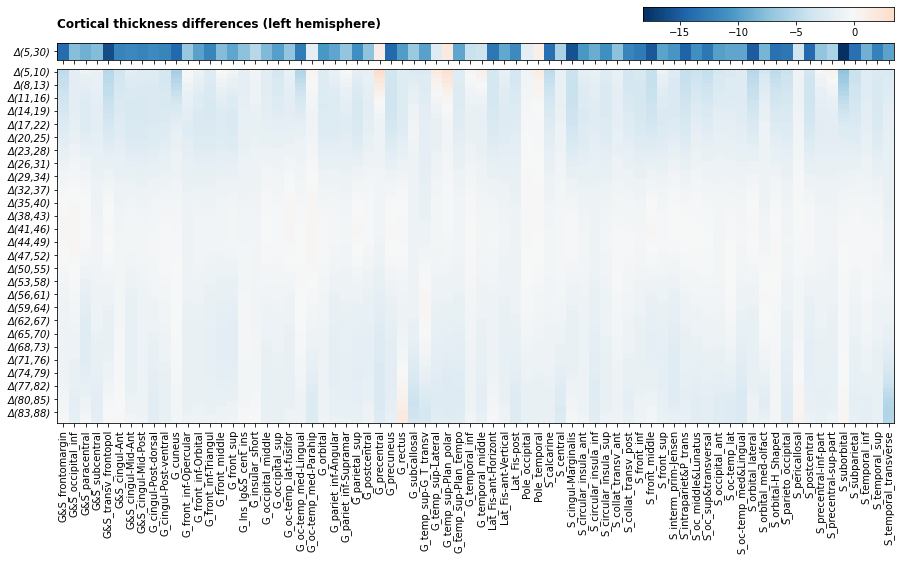

In [6]:
# show cortex development
fig, axes = plt.subplots(2,1, figsize=(15,7), sharex=True, gridspec_kw=dict(height_ratios=(0.05,1), 
                                                                            hspace=0.05))
# cbar axis
cax = inset_axes(axes[0],
                width="30%",  # width: 40% of parent_bbox width
                height="80%",  # height: 10% of parent_bbox height
                loc='upper right',
                bbox_to_anchor=(0, 2, 1, 1),
                bbox_transform=axes[0].transAxes,
                borderpad=0,
                )

# upper: whole dev
sns.heatmap(ct_diff["fm"][5][0.5].iloc[:1,:74] * 100, 
            center=0, ax=axes[0], cmap="RdBu_r", 
            cbar_kws=dict(orientation="horizontal"), cbar_ax=cax,
            vmin=ct_diff["fm"][5][0.5].values.min() * 100, 
            vmax=ct_diff["fm"][5][0.5].values.max() * 100)
axes[0].set_yticklabels(axes[0].get_yticklabels(), style="italic", rotation=0, ha="right")

# lower: step-wise
sns.heatmap(ct_diff["fm"][5][0.5].iloc[1:,:74] * 100, 
            center=0, ax=axes[1], cmap="RdBu_r", cbar=None,
            vmin=ct_diff["fm"][5][0.5].values.min() * 100, 
            vmax=ct_diff["fm"][5][0.5].values.max() * 100)
_ = axes[1].set_xticklabels([l.get_text().replace("lh_", "").replace("_thickness", "") \
    for l in axes[1].get_xticklabels()])
axes[1].set_yticklabels(axes[1].get_yticklabels(), style="italic")

# finish
axes[0].set_title("Cortical thickness differences (left hemisphere)", weight="semibold", 
                  x=0, ha="left", pad=15)
sns.despine(fig, top=False, bottom=False, left=False, right=False)

# save
fig.savefig(join(plot_dir_chart, f'dev_ct_steps.pdf'),  bbox_inches='tight')

#### Plot CT difference brains 1

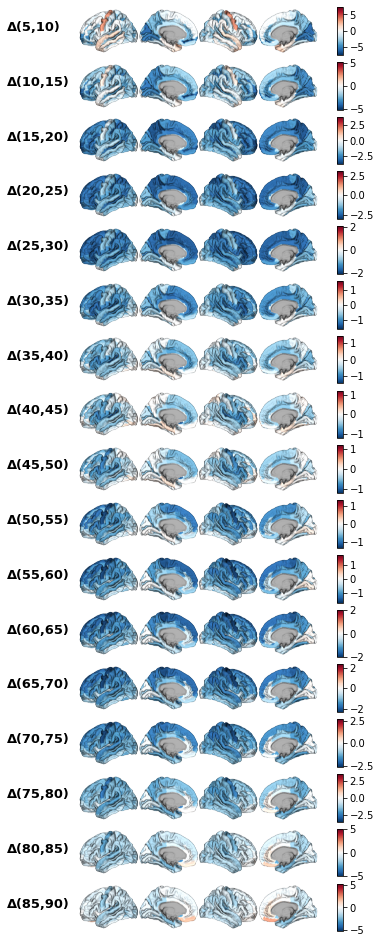

In [7]:
# prepare data
plot_index = tps_index[1::5]
plot_data = ct_diff_df["fm"][5].loc[(0.5,),:] * 100

# plot
fig, axes = plt.subplots(len(plot_index),2, figsize=(5,17),
                         gridspec_kw=dict(hspace=0.15, wspace=0.04, width_ratios=(1,0.02)))

# use if colorscale across all brains
#lim = np.abs(plot_data).max().max()

# iterate CT change periods
for i, idx in enumerate(plot_index):
    
    # use if individual coloscale for each brain
    lim = np.abs(plot_data.loc[idx,:]).max()
    
    # get parcellated gifti
    lh, rh = get_parc_gifti(plot_data.loc[idx,:])
    # plot
    plot_surf_ax(ax=axes[i,0], fig=fig, lh=lh, rh=rh, c="RdBu_r", c_lims=(-lim, lim))
    # label time period
    axes[i,0].annotate(idx, xy=(-0.3,0.5), xycoords="axes fraction", weight="semibold", size=13)
    
    # colorbar
    norm = mpl.colors.Normalize(-lim, lim)
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])
    cb = plt.colorbar(sm, cax=axes[i,1])
    
# save
fig.savefig(join(plot_dir_chart, "dev_ct_brains.png"), dpi=250, bbox_inches="tight")

#### Plot CT difference brains 2

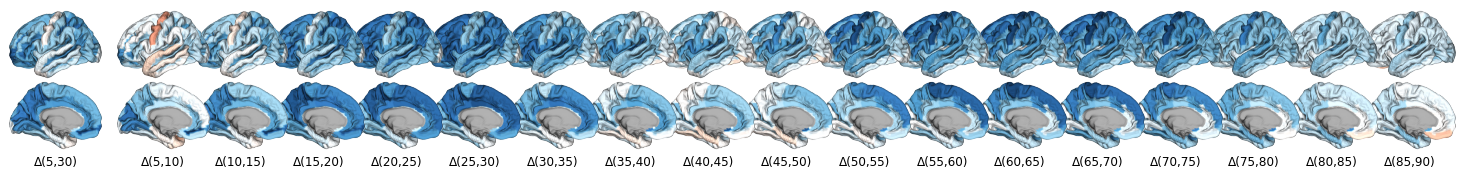

In [8]:
# get data
plot_index = [tps_index[0]] + tps_index[1::5]
plot_data = ct_diff_df["fm"][5].loc[(0.5,),:] * 100

# plot
fig, axes = plt.subplots(1,len(plot_index)+1, figsize=(26,2.7),
                         gridspec_kw=dict(wspace=-0.2, 
                                          width_ratios=(1,0.5) + tuple(np.ones(len(plot_index)-1))))

#lim = np.abs(plot_data).max().max()

# first plot (5-30 years)
idx = plot_index[0]
lim = np.abs(plot_data.loc[idx,:]).max()
lh, _ = get_parc_gifti(plot_data.loc[idx,:])
plot_surf_ax(axes[0], lh=lh, fig=fig, c="RdBu_r", c_lims=(-lim, lim), views=["lateral", "medial"], 
             size=(750,1100), layout="column", zoom=1.7, scale=(2, 2))
axes[0].annotate(idx, xy=(0.5,-0.1), xycoords="axes fraction", size=12, ha="center")
axes[0].set_zorder(len(plot_index))
axes[1].axis("off")

# next plots (5-year steps)
for i, idx in enumerate(plot_index[1:], start=2):
    lim = np.abs(plot_data.loc[idx,:]).max()
    lh, _ = get_parc_gifti(plot_data.loc[idx,:])
    plot_surf_ax(axes[i], lh=lh, fig=fig, c="RdBu_r", c_lims=(-lim, lim), views=["lateral", "medial"], 
                 size=(750,1100), layout="column", zoom=1.7, scale=(2, 2))
    axes[i].annotate(idx, xy=(0.5,-0.1), xycoords="axes fraction", size=12, ha="center")
    axes[i].set_zorder(len(plot_index)-i)
    
# save
fig.savefig(join(plot_dir_chart, "dev_ct_brainchain.png"), dpi=300, bbox_inches="tight")

In [9]:
# Alternative plot

# plot_index = [tps_index[0]] + tps_index[1::10]
# plot_data = ct_diff_df["fm"][5].loc[(0.5,),:] * 100
# fig, axes = plt.subplots(1,len(plot_index)+1, figsize=(23,3),
#                          gridspec_kw=dict(wspace=-0.2, 
#                                           width_ratios=(1,0.5) + tuple(np.ones(len(plot_index)-1))))

# #lim = np.abs(plot_data).max().max()
# # first plot
# idx = plot_index[0]
# lim = np.abs(plot_data.loc[idx,:]).max()
# lh, _ = get_parc_gifti(plot_data.loc[idx,:])
# plot_surf_ax(axes[0], lh=lh, fig=fig, c="RdBu_r", c_lims=(-lim, lim), views=["lateral", "medial"], 
#              size=(750,1100), layout="column", zoom=1.7, scale=(2, 2))
# axes[0].annotate(idx, xy=(0.5,1.07), xycoords="axes fraction", size=13, ha="center")
# axes[0].set_zorder(len(plot_index))
# norm = mpl.colors.Normalize(-lim, lim)
# sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
# sm.set_array([])
# cb = plt.colorbar(sm, orientation="horizontal", cax=axes[0].inset_axes((0.1,-0.1,0.8,0.05)))
# cb.set_label("CT change [%]")

# # placeholder
# axes[1].axis("off")

# # next plots
# for i, idx in enumerate(plot_index[1:], start=2):
#     lim = np.abs(plot_data.loc[idx,:]).max()
#     lh, _ = get_parc_gifti(plot_data.loc[idx,:])
#     plot_surf_ax(axes[i], lh=lh, fig=fig, c="RdBu_r", c_lims=(-lim, lim), views=["lateral", "medial"], 
#                  size=(750,1100), layout="column", zoom=1.7, scale=(2, 2))
#     axes[i].annotate(idx, xy=(0.5,1.07), xycoords="axes fraction", size=13, ha="center")
#     norm = mpl.colors.Normalize(-lim, lim)
#     sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
#     sm.set_array([])
#     cb = plt.colorbar(sm, orientation="horizontal", cax=axes[i].inset_axes((0.1,-0.1,0.8,0.05)))
#     cb.set_label("CT change [%]")
    
# fig.savefig(join(plot_dir_chart, "dev_ct_brainchain.png"), dpi=300, bbox_inches="tight")

## Perform simple linear regressions

### Run & get p-values

In [10]:
# Wrapper function to fit JuSpyce objects predicting CT change from brain atlases

def calculate_regression(sex="fm", centile=0.5, step=5, 
                         ct_diff_df=ct_diff_df, null_maps=None, 
                         save=True, save_suffix="", n_perm=n_perm,
                         dtype=np.float32):
    
    # JuSpyce: predict CT change from each brain atlas individually (simple linear regression)
    juspyce_ct_slr = JuSpyce(
        x=predictors_destrieux,
        y=ct_diff_df[sex][step].loc[(centile,),:], 
        data_space=juspyce_ct_spearman[sex].data_space,
        parcellation=juspyce_ct_spearman[sex].parc,
        parcellation_space=juspyce_ct_spearman[sex].parc_space,
        parcellation_density=juspyce_ct_spearman[sex].parc_density,
        standardize=juspyce_ct_spearman[sex].zscore,
        drop_nan=False,
        n_proc=8,
        dtype=dtype
    ).fit()
    
    # JuSpyce: predict CT change from multiple brain atlases (multivariate linear regression)
    # from imaging (PET+MRI)
    juspyce_ct_mlr_ni = JuSpyce(
        x=predictors_destrieux.loc[[c for c in predictors_destrieux.index if not c.startswith("ce")],:],
        y=ct_diff_df[sex][step].loc[(centile,),:],
        data_space=juspyce_ct_spearman[sex].data_space,
        parcellation=juspyce_ct_spearman[sex].parc,
        parcellation_space=juspyce_ct_spearman[sex].parc_space,
        parcellation_density=juspyce_ct_spearman[sex].parc_density,
        standardize=juspyce_ct_spearman[sex].zscore,
        drop_nan=False,
        n_proc=8,
        dtype=dtype
    ).fit()
    # from cell types (PET+MRI)
    juspyce_ct_mlr_ce = JuSpyce(
        x=predictors_destrieux.loc[[c for c in predictors_destrieux.index if c.startswith("ce")],:],
        y=ct_diff_df[sex][step].loc[(centile,),:], 
        data_space=juspyce_ct_spearman[sex].data_space,
        parcellation=juspyce_ct_spearman[sex].parc,
        parcellation_space=juspyce_ct_spearman[sex].parc_space,
        parcellation_density=juspyce_ct_spearman[sex].parc_density,
        standardize=juspyce_ct_spearman[sex].zscore,
        drop_nan=False,
        n_proc=8,
        dtype=dtype
    ).fit()
    
    # run SLR prediction
    juspyce_ct_slr.predict("slr", adjust_r2=True, verbose=True)
    # run MLR prediction
    juspyce_ct_slr.predict("mlr", adjust_r2=True, verbose=True, mlr_individual=False)
    juspyce_ct_mlr_ni.predict("mlr", adjust_r2=True, verbose=True, mlr_individual=False)
    juspyce_ct_mlr_ce.predict("mlr", adjust_r2=True, verbose=True, mlr_individual=False)
    
    # show
    #display(juspyce_ct_slr.predictions["slr"])
    
    # get null-based p-values
    juspyce_ct_slr.permute_maps("slr", permute="X", seed=42, n_perm=n_perm, null_maps=null_maps)
    juspyce_ct_slr.permute_maps("mlr", permute="X", seed=42, n_perm=n_perm)
    # use already generated null maps to speed things up
    if null_maps is None:
        null_maps = juspyce_ct_slr.nulls["null_maps"]
    juspyce_ct_mlr_ni.permute_maps("mlr", permute="X", seed=42, n_perm=n_perm, null_maps=null_maps,
                                   mlr_individual=False)
    juspyce_ct_mlr_ce.permute_maps("mlr", permute="X", seed=42, n_perm=n_perm, null_maps=null_maps,
                                   mlr_individual=False)
    
    # correct p-values for multiple comparisons
    juspyce_ct_slr.correct_p(mc_method="fdr_bh")
    juspyce_ct_mlr_ni.correct_p(mc_method="fdr_bh")
    juspyce_ct_mlr_ce.correct_p(mc_method="fdr_bh")
    
    # show
    #display(juspyce_ct_slr.p_predictions["slr"])
    
    # save
    if save:
        juspyce_ct_slr.to_pickle(
            join(rutherford_dir, 
                 f"juspyce_ct_slr_{sex}_{str(int(centile*1000)).zfill(3)}_{step}{save_suffix}.pkl.gz"), 
            save_nulls=True
        )
        juspyce_ct_mlr_ni.to_pickle(
            join(rutherford_dir, 
                 f"juspyce_ct_mlr_ni_{sex}_{str(int(centile*1000)).zfill(3)}_{step}{save_suffix}.pkl.gz"), 
            save_nulls=True
        )
        juspyce_ct_mlr_ce.to_pickle(
            join(rutherford_dir, 
                 f"juspyce_ct_mlr_ce_{sex}_{str(int(centile*1000)).zfill(3)}_{step}{save_suffix}.pkl.gz"), 
            save_nulls=True
        )    

    # return
    return juspyce_ct_slr, juspyce_ct_mlr_ni, juspyce_ct_mlr_ce

In [11]:
# run
# recalculate
if rerun_regression:
    # default
    print("fm, 0.5th centile, step 5 year")
    juspyce_ct_slr, juspyce_ct_mlr_ni, juspyce_ct_mlr_ce = \
        calculate_regression("fm", 0.5)    
    # single sexes
    print("f, 0.5th centile, step 5 year")
    juspyce_ct_slr_f, juspyce_ct_mlr_ni_f, juspyce_ct_mlr_ce_f = \
        calculate_regression("f", 0.5, null_maps=juspyce_ct_slr.nulls["null_maps"])
    print("m, 0.5th centile, step 5 year")
    juspyce_ct_slr_m, juspyce_ct_mlr_ni_m, juspyce_ct_mlr_ce_m = \
        calculate_regression("m", 0.5, null_maps=juspyce_ct_slr.nulls["null_maps"])
    # other centiles
    print("fm, 0.01th centile, step 5 year")
    juspyce_ct_slr_010, juspyce_ct_mlr_ni_010, juspyce_ct_mlr_ce_010 = \
        calculate_regression("fm", 0.01, null_maps=juspyce_ct_slr.nulls["null_maps"])
    print("fm, 0.99th centile, step 5 year")
    juspyce_ct_slr_990, juspyce_ct_mlr_ni_990, juspyce_ct_mlr_ce_990 = \
        calculate_regression("fm", 0.99, null_maps=juspyce_ct_slr.nulls["null_maps"])
    # step size
    print("fm, 0.5th centile, step 1 year")
    juspyce_ct_slr_1, juspyce_ct_mlr_ni_1, juspyce_ct_mlr_ce_1 = \
        calculate_regression("fm", 0.5, step=1, null_maps=juspyce_ct_slr.nulls["null_maps"])
    print("fm, 0.5th centile, step 2 year")
    juspyce_ct_slr_2, juspyce_ct_mlr_ni_2, juspyce_ct_mlr_ce_2 = \
        calculate_regression("fm", 0.5, step=2, null_maps=juspyce_ct_slr.nulls["null_maps"])
    # baseline-corrected
    print("fm, 0.5th centile, step 5 year, corrected for baseline")
    juspyce_ct_slr_blcorr, juspyce_ct_mlr_ni_blcorr, juspyce_ct_mlr_ce_blcorr = \
        calculate_regression("fm", 0.5, null_maps=juspyce_ct_slr.nulls["null_maps"],
                             ct_diff_df=ct_diff_blcorr_df, save_suffix="_blcorr")    
    
     
# load from file
else:
    # default
    juspyce_ct_slr, juspyce_ct_mlr_ni, juspyce_ct_mlr_ce = \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_slr_fm_500_5.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ni_fm_500_5.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ce_fm_500_5.pkl.gz"))
    # single sexes
    juspyce_ct_slr_f, juspyce_ct_mlr_ni_f, juspyce_ct_mlr_ce_f = \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_slr_f_500_5.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ni_f_500_5.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ce_f_500_5.pkl.gz"))
    juspyce_ct_slr_m, juspyce_ct_mlr_ni_m, juspyce_ct_mlr_ce_m = \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_slr_m_500_5.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ni_m_500_5.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ce_m_500_5.pkl.gz"))
    # other centiles
    juspyce_ct_slr_010, juspyce_ct_mlr_ni_010, juspyce_ct_mlr_ce_010 = \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_slr_fm_010_5.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ni_fm_010_5.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ce_fm_010_5.pkl.gz"))
    juspyce_ct_slr_990, juspyce_ct_mlr_ni_990, juspyce_ct_mlr_ce_990 = \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_slr_fm_990_5.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ni_fm_990_5.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ce_fm_990_5.pkl.gz"))
    # step size
    juspyce_ct_slr_1, juspyce_ct_mlr_ni_1, juspyce_ct_mlr_ce_1 = \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_slr_fm_500_1.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ni_fm_500_1.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ce_fm_500_1.pkl.gz"))
    juspyce_ct_slr_2, juspyce_ct_mlr_ni_2, juspyce_ct_mlr_ce_2 = \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_slr_fm_500_2.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ni_fm_500_2.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ce_fm_500_2.pkl.gz"))
    # baseline-corrected
    juspyce_ct_slr_blcorr, juspyce_ct_mlr_ni_blcorr, juspyce_ct_mlr_ce_blcorr = \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_slr_fm_500_5_blcorr.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ni_fm_500_5_blcorr.pkl.gz")), \
        JuSpyce.from_pickle(join(rutherford_dir, f"juspyce_ct_mlr_ce_fm_500_5_blcorr.pkl.gz"))

INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_slr_fm_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_mlr_ni_fm_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_mlr_ce_fm_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_slr_f_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_mlr_ni_f_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_mlr_ce_f_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_slr_m_500_5.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_mlr_ni_m_500_5.pkl.gz.
INFO:j

### Results overview

In [12]:
print("Neuroimaging MLR")
display(juspyce_ct_mlr_ni.predictions["mlr_full_r2"].max())
print("Cell type MLR")
display(juspyce_ct_mlr_ce.predictions["mlr_full_r2"].max())
print("Combined MLR")
display(juspyce_ct_slr.predictions["mlr_full_r2"].max())
print("Predictor-wise SLR")
display(juspyce_ct_slr.predictions["slr"].max())

Neuroimaging MLR


mlr_full_r2    0.543889
dtype: float32

Cell type MLR


mlr_full_r2    0.53586
dtype: float32

Combined MLR


mlr_full_r2    0.673297
dtype: float32

Predictor-wise SLR


ni1-SV2A-M1-mGluR5-5HT6-CB1-GABAa-HDAC    0.058665
ni2-5HT2a-5HT4-5HT1a-5HTT                 0.134631
ni3-FDOPA-DAT-D1-NMDA                     0.221313
ni4-GI-5HT1b-MU-A4B2                      0.295606
ni5-VAChT-NET                             0.377450
ni6-CBF-CMRglu                            0.267989
ni7-COX1                                  0.136250
ni8-H3                                    0.106521
ni9-D2                                    0.374751
ni10-TSPO                                 0.059453
ce1-Ex7-In4-Ex5-Ex4-In1                   0.099578
ce2-Oligo-Endo                            0.020774
ce3-Micro-OPC                             0.236558
ce4-In3-In2-Astro                         0.179435
ce5-In6-Ex2                               0.302289
ce6-Ex8-Ex6                               0.131906
ce7-In7-Ex3                               0.156374
ce8-In5                                   0.135881
ce9-In8                                   0.154611
ce10-Ex1                       

### Choose predictors

Based on female-male-averaged 0.5th-centile 5-year-step data. Will be taken into dominance analysis.

In [13]:
how = "p_fdr" # ["p", "p_fdr"]
p_thresh = 0.05
method = "slr"

if how=="p":
    # get p dataframes
    slr_sig = (juspyce_ct_slr.p_predictions[method] < p_thresh).any()
elif how=="p_fdr":
    # get p-fdr dataframes
    slr_sig = (juspyce_ct_slr.p_predictions[method+"--fdr_bh"] < p_thresh).any()

# identify significant predictors
predictors_sig = slr_sig[slr_sig==True].index.to_list()
print(f"{how} < {p_thresh}: n = {len(predictors_sig)}\n", predictors_sig)

p_fdr < 0.05: n = 9
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8']


### Plot predictor-wise regression 

#### Plot functions

In [14]:
## single plot function

def plot_diffs(
    data, data_p, data_total, data_total_p, ax, 
    data_null=None, 
    title="", cmap="tab10", annotate_pctl=False, prct_annot_pad=0.04,
    legend_size=12, legend_color="linecolor", total_color="0.3"
    ):
    
    # layout settings
    pred = list(data.columns) if data is not None else data_total.columns
    colors = get_cmap(cmap)(range(len(pred))) if len(pred) <= 10 else \
        np.r_[get_cmap(cmap)(range(10)), np.repeat([[0,0,0,1]], len(pred)-10, 0)]
    alpha_med = 0.7
    alpha_text = 0.4
    size_text = 11
    pos_text = [-0.015,0.025] #if data is not None else [-0.015,0.03]
    x_lab = (data.index if data is not None else data_total.index).to_list()
    
    # null r2 shades
    if data_null is not None:
        for pz, pz_color in zip([(1,99), (5,95), (25,75)], ["0.97", "0.93", "0.89"]):
            ax.fill_between(
                x=x_lab[1:],
                y1=np.percentile(data_null, pz[0], axis=0)[1:],
                y2=np.percentile(data_null, pz[1], axis=0)[1:],
                lw=0,
                color=pz_color,
                zorder=-100
            )
            if annotate_pctl:
                ax.annotate("Null distribution\n[percentiles]", 
                            (0.8, np.percentile(data_null.iloc[:,1], 99) + prct_annot_pad), 
                            va="center", c="0.4")
                ax.annotate(f"{pz[0]}.", (0.8, np.percentile(data_null.iloc[:,1], pz[0])), 
                            va="center", c="0.2")
                ax.annotate(f"{pz[1]}.", (0.8, np.percentile(data_null.iloc[:,1], pz[1])), 
                            va="center", c="0.2")
        
    # total r2 lines
    if data_total is not None:
        ax.plot(list(data_total.index[1:]), data_total.iloc[1:,0], 
                color=total_color, alpha=1, 
                label="Combined markers ★")
        if data_total_p is not None:
            for x, (y, p) in enumerate(zip(data_total.iloc[1:,0], data_total_p.values[1:])):
                ax.text(x+pos_text[0], y+pos_text[1], p[0], 
                        ha="center", va="top", color=total_color, alpha=0.8, size=size_text)
        
    # predictor r2 lines
    if data is not None:
        
        for i, p in enumerate(pred):
            
            label = rename_myelin(p, "mr1-Microstr")
            if data_p is not None:
                if "★" in data_p[p][1:].to_list():
                    label = label + " ★"
                elif "☆" in data_p[p][1:].to_list():
                    label = label + " ☆"
                
            ax.plot(list(data.index[1:]), data[p][1:], color=colors[i], alpha=alpha_med, label=label)
            
            if data_p is not None:
                for x, (y, p_val) in enumerate(zip(data[p][1:], data_p[p][1:])):
                    ax.text(x+pos_text[0], y+pos_text[1], p_val, ha="center", va="top", 
                            color=colors[i], alpha=alpha_text+0.3, size=size_text)    
    
    # layout
    ax.legend(loc="upper right", ncol=3, prop={'size': legend_size}, labelcolor=legend_color) \
        .set_title(title, prop=dict(size=12))
    ax.set_xticks(list(np.arange(0,86,5)))
    ax.set_xticks(list(range(89)), minor=True)
    ax.set_xticklabels(x_lab[1::5] + [""], rotation=-30, ha="left", rotation_mode="anchor")
    ax.set_xlim(-0.8, data.shape[0] if data is not None else data_total.shape[0] - 1.2)
    ax.tick_params(axis="both", which="major", labelsize=11)
    
    
## Function to add developmental stages (aligned to CT change period mean, e.g. delta(5,10) = 7.5)
def add_stages(
    ax, height=0.09,
    alignment=-2.5,
    stages=[(6,12), (12,20), (20,40), (40,60), (60,100)],
    stage_names=["Late childhood", "Adolescence", "Young adulthood", "Middle adulthood", "Late adulthood"]
    ):
    
    ax_stages = ax.inset_axes((0, 1, 1, height))
    ax_stages.set_xlim(ax.get_xlim())
    ax_stages.set_ylim(0,1)
    ax_stages.set_axis_off()
    
    for i, x_range in enumerate(stages):
        x0 = x_range[0] - 5 + alignment
        x1 = x_range[1] - 5 + alignment
        if x_range[0] > 10:
            ax_stages.axvline(
                x0, 
                c="0.3",
                lw=1,
                zorder=0
            )
        if x0 < 2:
            x0 = -5
        if x1 > 90:
            x1 = 80
        ax_stages.text(
            x=(x0 + x1) / 2,
            y=0.5,
            s=f"{stage_names[i]}\n${x_range[0]} - {x_range[1]}\ y.$",
            ha="center",
            va="center"
        )
        

## multiplot function
def plot_regression(juspyce_ct_slr, juspyce_ct_mlr_ni, juspyce_ct_mlr_ce, 
                    save_path=None, plot=False, return_fig=False, method="slr", n_perm=n_perm):

    # sign predictors
    # get p-fdr dataframes
    slr_sig = (juspyce_ct_slr.p_predictions["slr--fdr_bh"] < 0.05).any()
    # identify significant predictors
    predictors_sig = slr_sig[slr_sig==True].index.to_list()
    print(f"p_fdr < 0.05: n = {len(predictors_sig)}\n", predictors_sig)
    
    # figure
    fig, axes = plt.subplots(2,2, figsize=(23.5,12), sharey=False)
    fig.patch.set_facecolor('w')

    ## first column: ni predictors
    ni_predictors = [p for p in juspyce_ct_slr.predictions[method].columns if not p.startswith("ce")]
    ni_predictors_idx = [list(juspyce_ct_slr.predictions[method].columns).index(p) \
        for p in ni_predictors]
    plot_diffs(
        data=None, 
        data_p=None,
        data_total=juspyce_ct_mlr_ni.predictions["mlr_full_r2"],
        data_total_p=p_to_ast(juspyce_ct_mlr_ni.p_predictions["mlr_full_r2"], 
                              juspyce_ct_mlr_ni.p_predictions["mlr_full_r2--fdr_bh"]),
        data_null=pd.DataFrame(
            np.c_[[juspyce_ct_mlr_ni.nulls["predictions-mlr"][i]["mlr_full_r2"][:,0] \
                for i in range(n_perm)]],
            index=range(n_perm),
            columns=juspyce_ct_mlr_ni.y_lab
        ),
        annotate_pctl=True,
        ax=axes[0,0],
        legend_size=13,
        total_color="#DF5336"
    )
    plot_diffs(
        data=juspyce_ct_slr.predictions[method][ni_predictors], 
        data_p=p_to_ast(juspyce_ct_slr.p_predictions[method][ni_predictors], 
                        juspyce_ct_slr.p_predictions[method+"--fdr_bh"][ni_predictors]),
        data_total=None, 
        data_total_p=None, 
        data_null=pd.DataFrame(
            data=np.column_stack([juspyce_ct_slr.nulls["predictions-slr"][i]["slr"][:, ni_predictors_idx] \
                for i in range(n_perm)]).T,
            index=range(n_perm*len(ni_predictors)),
            columns=juspyce_ct_slr.y_lab
        ),
        ax=axes[1,0],
        legend_size=13
    )
    # age stages
    add_stages(axes[0,0])
    

    ## second column: cell predictors
    ce_predictors = [p for p in juspyce_ct_slr.predictions[method].columns if p.startswith("ce")]
    ce_predictors_idx = [list(juspyce_ct_slr.predictions[method].columns).index(p) \
        for p in ce_predictors]
    plot_diffs(
        data=None, data_p=None,
        data_total=juspyce_ct_mlr_ce.predictions["mlr_full_r2"],
        data_total_p=p_to_ast(juspyce_ct_mlr_ce.p_predictions["mlr_full_r2"], 
                              juspyce_ct_mlr_ce.p_predictions["mlr_full_r2--fdr_bh"]),
        data_null=pd.DataFrame(
            np.c_[[juspyce_ct_mlr_ce.nulls["predictions-mlr"][i]["mlr_full_r2"][:,0] \
                for i in range(n_perm)]],
            index=range(n_perm),
            columns=juspyce_ct_mlr_ce.y_lab
        ),
        annotate_pctl=True,
        ax=axes[0,1],
        legend_size=13,
        total_color="#20A486"
    )
    plot_diffs(
        data=juspyce_ct_slr.predictions[method][ce_predictors], 
        data_p=p_to_ast(juspyce_ct_slr.p_predictions[method][ce_predictors], 
                        juspyce_ct_slr.p_predictions[method+"--fdr_bh"][ce_predictors]),
        data_total=None, 
        data_total_p=None, 
        data_null=pd.DataFrame(
            data=np.column_stack([juspyce_ct_slr.nulls["predictions-slr"][i]["slr"][:, ce_predictors_idx] \
                for i in range(n_perm)]).T,
            index=range(n_perm*len(ce_predictors)),
            columns=juspyce_ct_slr.y_lab
        ),
        ax=axes[1,1],
        legend_size=13
    )
    # age stages
    add_stages(axes[0,1])

    # finish
    for r in range(2):
        for c in range(2):
            # y limits
            axes[r,c].set_ylim(-0.015, 0.615) #if r==0 else axes[r,c].set_ylim(-0.01, 0.5)
            # y label
            axes[r,0].set_ylabel("CT change explained [$adjusted\ R^2$]", size=14, labelpad=10)
            # x label
            axes[-1,c].set_xlabel("Age windows [5-year steps]", size=14, labelpad=11)
    # title
    axes[0,0].set_title("Molecular neurobiological markers (PET) and cortical microstructure (MRI)", size=15, pad=20)
    axes[0,1].set_title("Cellular neurobiological markers (gene expression)", size=15, pad=20)

    # correct too long x-axis, no idea where that comes from
    [axes[1,c].set_xlim(axes[0,c].get_xlim()) for c in range(2)]

    fig.tight_layout()
    if save_path is not None: fig.savefig(save_path,  bbox_inches='tight')
    if plot: plt.show()
    plt.close()
    if return_fig: return fig, axes
            
        
# full regression model plot function
def plot_regression_full(juspyce_ct_slr, save_path=None, plot=False, return_fig=False, n_perm=n_perm):
    fig, ax = plt.subplots(1, figsize=(12,6.5))
    plot_diffs(data=None, data_p=None,
        data_total=juspyce_ct_slr.predictions["mlr_full_r2"],
        data_total_p=p_to_ast(juspyce_ct_slr.p_predictions["mlr_full_r2"], 
                              juspyce_ct_slr.p_predictions["mlr_full_r2--fdr_bh"]),
        data_null=pd.DataFrame(
            np.c_[[juspyce_ct_slr.nulls["predictions-mlr"][i]["mlr_full_r2"][:,0] \
                for i in range(n_perm)]],
            index=range(n_perm),
            columns=juspyce_ct_slr.y_lab
        ),
        annotate_pctl=True,
        prct_annot_pad=0.06,
        ax=ax,
        legend_size=14,
        legend_color="0.2"
    )
    ax.set_ylim(-0.01, None)
    ax.set_ylabel("CT change explained [$adjusted\ R^2$]", size=14, labelpad=10)
    ax.set_xlabel("Age windows [5-year steps]", size=14, labelpad=11)
    ax.set_title("Combined neurobiological markers", size=15, pad=11)
    
    add_stages(ax)

    fig.tight_layout()
    if save_path is not None: fig.savefig(save_path,  bbox_inches='tight')
    if plot: plt.show()
    plt.close()
    if return_fig: return fig, ax

#### Plot

p_fdr < 0.05: n = 9
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8']


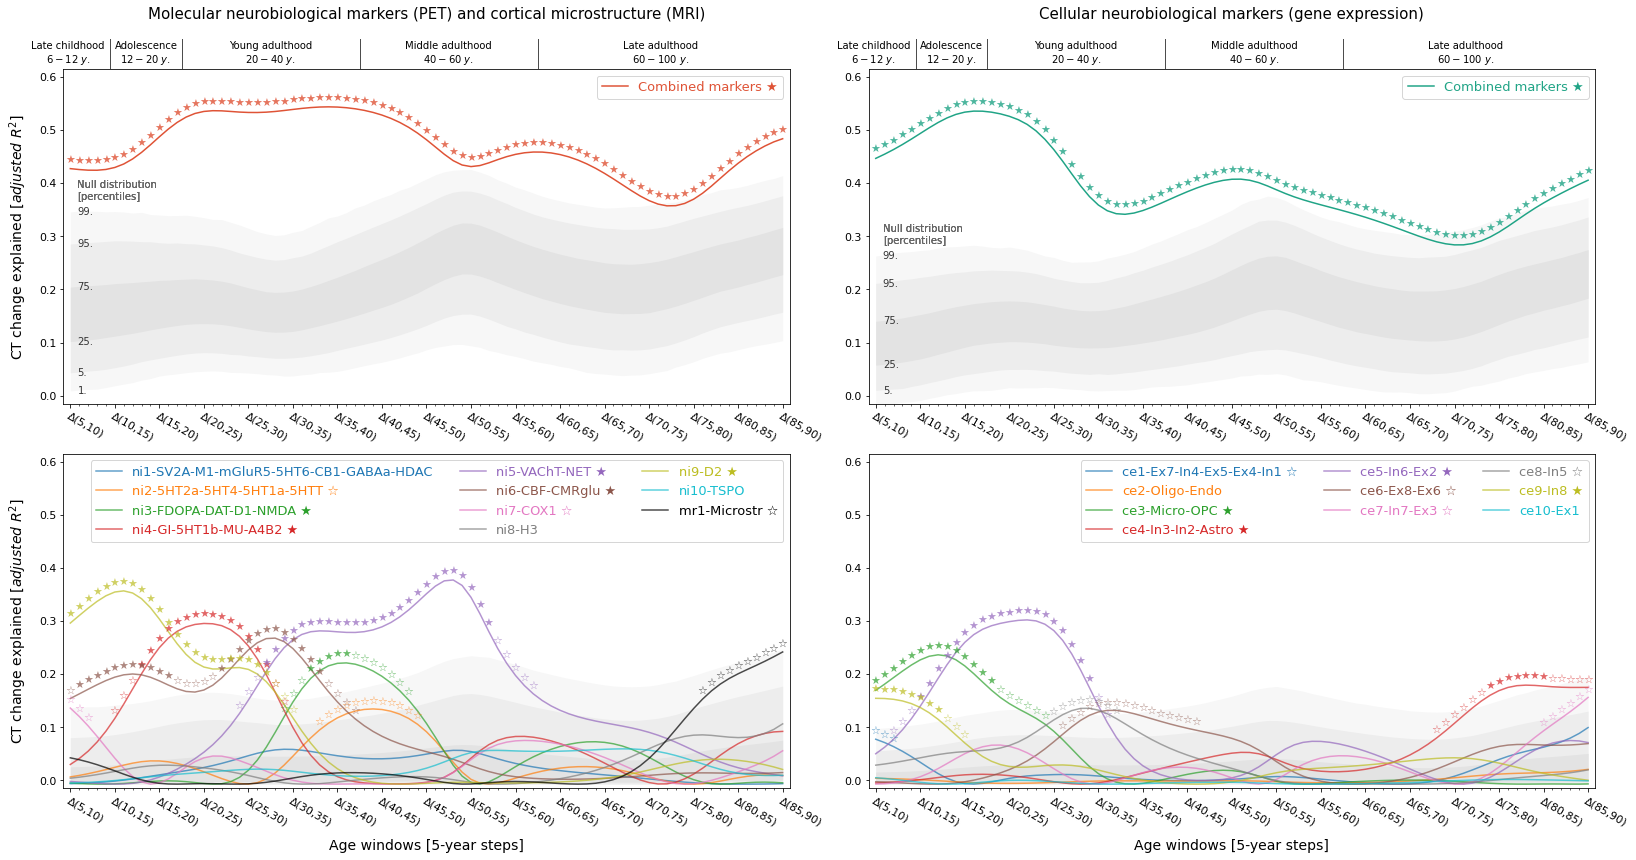

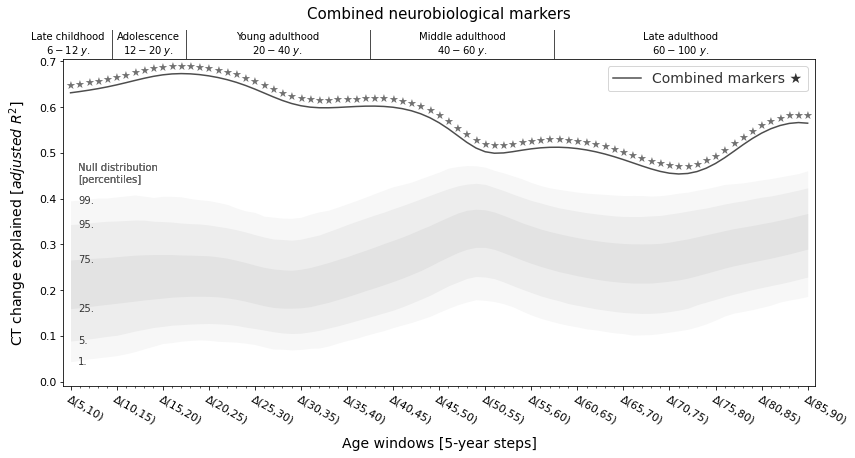

In [15]:
## plot main predictions 

# default
plot_regression(
    juspyce_ct_slr, juspyce_ct_mlr_ni, juspyce_ct_mlr_ce, 
    save_path=join(plot_dir_reg, f'dev_ct_regression_fm_500_5.pdf'), 
    plot=True
)
plot_regression_full(
    juspyce_ct_slr, 
    save_path=join(plot_dir_reg, f'dev_ct_regression_all_fm_500_5.pdf'),
    plot=True
)

In [16]:
# plot sensitivity analyses

# sexes: female
plot_regression(juspyce_ct_slr_f, juspyce_ct_mlr_ni_f, juspyce_ct_mlr_ce_f, 
                join(plot_dir_reg, f'dev_ct_regression_f_500_5.pdf'))
plot_regression_full(juspyce_ct_slr_f, join(plot_dir_reg, f'dev_ct_regression_all_f_500_5.pdf'))
# sexes: male
plot_regression(juspyce_ct_slr_m, juspyce_ct_mlr_ni_m, juspyce_ct_mlr_ce_m, 
                join(plot_dir_reg, f'dev_ct_regression_m_500_5.pdf'))
plot_regression_full(juspyce_ct_slr_m, join(plot_dir_reg, f'dev_ct_regression_all_m_500_5.pdf'))
# centiles: 1st
plot_regression(juspyce_ct_slr_010, juspyce_ct_mlr_ni_010, juspyce_ct_mlr_ce_010, 
                join(plot_dir_reg, f'dev_ct_regression_fm_010_5.pdf'))
plot_regression_full(juspyce_ct_slr_010, join(plot_dir_reg, f'dev_ct_regression_all_fm_010_5.pdf'))
# centiles: 99th
plot_regression(juspyce_ct_slr_990, juspyce_ct_mlr_ni_990, juspyce_ct_mlr_ce_990, 
                join(plot_dir_reg, f'dev_ct_regression_fm_990_5.pdf'))
plot_regression_full(juspyce_ct_slr_990, join(plot_dir_reg, f'dev_ct_regression_all_fm_990_5.pdf'))
# step size: 1
plot_regression(juspyce_ct_slr_1, juspyce_ct_mlr_ni_1, juspyce_ct_mlr_ce_1, 
                join(plot_dir_reg, f'dev_ct_regression_fm_500_1.pdf'))
plot_regression_full(juspyce_ct_slr_1, join(plot_dir_reg, f'dev_ct_regression_all_fm_500_1.pdf'))
# step size: 2
plot_regression(juspyce_ct_slr_2, juspyce_ct_mlr_ni_2, juspyce_ct_mlr_ce_2, 
                join(plot_dir_reg, f'dev_ct_regression_fm_500_2.pdf'))
plot_regression_full(juspyce_ct_slr_2, join(plot_dir_reg, f'dev_ct_regression_all_fm_500_2.pdf'))
# baseline-corrected
plot_regression(juspyce_ct_slr_blcorr, juspyce_ct_mlr_ni_blcorr, juspyce_ct_mlr_ce_blcorr, 
                join(plot_dir_reg, f'dev_ct_regression_fm_500_5_blcorr.pdf'))
plot_regression_full(juspyce_ct_slr_blcorr, 
                     join(plot_dir_reg, f'dev_ct_regression_all_fm_500_5_blcorr.pdf'))

p_fdr < 0.05: n = 9
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8']
p_fdr < 0.05: n = 9
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8']
p_fdr < 0.05: n = 10
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8', 'mr1-myelin']
p_fdr < 0.05: n = 8
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce5-In6-Ex2', 'ce9-In8']
p_fdr < 0.05: n = 9
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8']
p_fdr < 0.05: n = 9
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 

## Perform dominance analysis

### Dominance function

In [17]:
# function
def calculate_dominance(x, sex="fm", centile=0.5, step=5, n_perm=n_perm, 
                        null_maps=None, dist_mat=None, save_path=None):

    # initialize
    juspyce_ct_dominance = JuSpyce(
        x=x,
        y=ct_diff_df[sex][step].loc[(centile,),:],
        data_space=juspyce_ct_spearman[sex].data_space,
        parcellation=juspyce_ct_spearman[sex].parc,
        parcellation_space=juspyce_ct_spearman[sex].parc_space,
        parcellation_density=juspyce_ct_spearman[sex].parc_density,
        standardize=juspyce_ct_spearman[sex].zscore,
        drop_nan=False,
        n_proc=8
    ).fit()
    # run dominance analysis
    juspyce_ct_dominance.predict("dominance", adjust_r2=True, verbose=True)
    # for plotting: spearman correlations
    juspyce_ct_dominance.predict("spearman", r_to_z=True, verbose=True, n_proc=1)
    # get p-values, use null maps from above
    juspyce_ct_dominance.permute_maps("dominance", permute="X", seed=42, n_perm=n_perm, 
                                      null_maps=null_maps, dist_mat=dist_mat)
    juspyce_ct_dominance.correct_p(mc_method="fdr_bh")
    # save
    if save_path is not None: 
        juspyce_ct_dominance.to_pickle(save_path, save_nulls=True)
    # return
    return juspyce_ct_dominance

### Run main analysis & get p-values

In [18]:
# run
# recalculate
if rerun_dominance:
    # default
    print("fm, 0.5th centile, step 5 year")
    juspyce_ct_dominance = calculate_dominance(
        x=predictors_destrieux.loc[predictors_sig,:],
        sex="fm", 
        centile=0.5, 
        null_maps=juspyce_ct_slr.nulls["null_maps"],
        save_path=join(rutherford_dir, f"juspyce_ct_dominance_fm_500_5.pkl.gz"))

# load from file
else:
    juspyce_ct_dominance = JuSpyce.from_pickle(\
        join(rutherford_dir, f"juspyce_ct_dominance_fm_500_5.pkl.gz"))
    
# significant predictors
# get p-fdr dataframes
dom_sig = (juspyce_ct_dominance.p_predictions["dominance_total--fdr_bh"] < 0.05).any()
# identify significant predictors
predictors_sig_dom = dom_sig[dom_sig==True].index.to_list()
print(f"p_fdr < 0.05: n = {len(predictors_sig_dom)}\n", predictors_sig_dom)

INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_fm_500_5.pkl.gz.


p_fdr < 0.05: n = 6
 ['ni3-FDOPA-DAT-D1-NMDA', 'ni5-VAChT-NET', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce9-In8']


#### Results overview

In [19]:
print("Total R2 -- 5-30 years")
display(juspyce_ct_dominance.predictions["dominance_full_r2"].iloc[0,:])
print("Predictor-wise R2 -- 5-30 years")
display(juspyce_ct_dominance.predictions["dominance_total"].iloc[0,:])
print("Total R2 -- lifespan")
display(juspyce_ct_dominance.predictions["dominance_full_r2"].iloc[1:,:].max())
print("Predictor-wise R2 -- lifespan")
display(juspyce_ct_dominance.predictions["dominance_total"].iloc[1:,:].max())

Total R2 -- 5-30 years


dominance_full_r2    0.580011
Name: Δ(5,30), dtype: float32

Predictor-wise R2 -- 5-30 years


ni3-FDOPA-DAT-D1-NMDA    0.006961
ni4-GI-5HT1b-MU-A4B2     0.042977
ni5-VAChT-NET            0.010976
ni6-CBF-CMRglu           0.088986
ni9-D2                   0.164059
ce3-Micro-OPC            0.120381
ce4-In3-In2-Astro        0.033244
ce5-In6-Ex2              0.043588
ce9-In8                  0.068839
Name: Δ(5,30), dtype: float32

Total R2 -- lifespan


dominance_full_r2    0.573838
dtype: float32

Predictor-wise R2 -- lifespan


ni3-FDOPA-DAT-D1-NMDA    0.215213
ni4-GI-5HT1b-MU-A4B2     0.128902
ni5-VAChT-NET            0.278498
ni6-CBF-CMRglu           0.091122
ni9-D2                   0.163250
ce3-Micro-OPC            0.124852
ce4-In3-In2-Astro        0.140864
ce5-In6-Ex2              0.108132
ce9-In8                  0.121406
dtype: float32

### Run analysis across all original predictors & get p-values

In [20]:
juspyce_ct_dominance_single = dict()
predictors_sig_loadings = dict()

for pred in predictors_sig:
    
    # get all original maps that load > 0.4 on the current predictor (factor)
    loadings = pd.read_csv(
        join(predictor_dir, f"{'ni' if pred.startswith('ni') else 'cell'}_factorloadings_destrieux.csv"),
        index_col=0
    )
    # top five predictors if > 0.3
    temp = loadings[pred].abs().sort_values(ascending=False)[:5]
    temp = temp[temp >= 0.3].index
    
    predictors_sig_loadings[pred] = {
        #"predictors": loadings[loadings > 0.4].index.to_list(),
        #"loadings": loadings[loadings > 0.4].to_list(),
        "predictors": loadings.loc[temp, pred].index.to_list(),
        "loadings": loadings.loc[temp, pred].to_list(),
    }
    print(pred, ": ", predictors_sig_loadings[pred]["predictors"])
    
    if rerun_dominance_single:
        # run dominance analysis
        juspyce_ct_dominance_single[pred] = calculate_dominance(
            x=predictors_destrieux_original.loc[predictors_sig_loadings[pred]["predictors"], :], 
            sex="fm", 
            centile=0.5,
            n_perm=n_perm,
            dist_mat=juspyce_ct_slr.nulls["distance_matrix"],
            save_path= \
                join(rutherford_dir, f"juspyce_ct_dominance_single_{pred.split('-')[0]}_fm_500_5.pkl.gz")
        )
        
    else:
        # load from file
        juspyce_ct_dominance_single[pred] = JuSpyce.from_pickle(
                join(rutherford_dir, f"juspyce_ct_dominance_single_{pred.split('-')[0]}_fm_500_5.pkl.gz")
        )
        

ni3-FDOPA-DAT-D1-NMDA :  ['FDOPA', 'DAT', 'D1', 'NET', 'NMDA']


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ni3_fm_500_5.pkl.gz.


ni4-GI-5HT1b-MU-A4B2 :  ['GI', '5HT1b', 'MU', 'A4B2', '5HT6']


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ni4_fm_500_5.pkl.gz.


ni5-VAChT-NET :  ['VAChT', 'NET', 'A4B2']


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ni5_fm_500_5.pkl.gz.


ni6-CBF-CMRglu :  ['CBF', 'CMRglu']


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ni6_fm_500_5.pkl.gz.


ni9-D2 :  ['GABAa', 'D2', 'D1']


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ni9_fm_500_5.pkl.gz.


ce3-Micro-OPC :  ['Micro', 'OPC', 'Ex3', 'In2']


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ce3_fm_500_5.pkl.gz.


ce4-In3-In2-Astro :  ['In3', 'In2', 'Astro']


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ce4_fm_500_5.pkl.gz.


ce5-In6-Ex2 :  ['In6', 'Ex2', 'In4']


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ce5_fm_500_5.pkl.gz.


ce9-In8 :  ['In8', 'Ex3']


INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_single_ce9_fm_500_5.pkl.gz.


#### FDR correction across all panels

In [206]:
## single dominance analyses
ct_dominance_single_sig_dom = dict()

# iterate predictors
for pred in predictors_sig:
    # concat total and full R2 dominance p values
    ct_dominance_single_sig_dom[pred] = pd.concat([
        juspyce_ct_dominance_single[pred].p_predictions["dominance_full_r2"],
        juspyce_ct_dominance_single[pred].p_predictions["dominance_total"]
    ], axis=1).melt(var_name="pred_orig", value_name="p", ignore_index=False)
    # add index
    ct_dominance_single_sig_dom[pred] = ct_dominance_single_sig_dom[pred].set_index(["pred_orig"], append=True)
# concat to one long df
ct_dominance_single_sig_dom = pd.concat(ct_dominance_single_sig_dom)
# FDR correction
ct_dominance_single_sig_dom["q"] = mc_correction(ct_dominance_single_sig_dom)[0]
# index
ct_dominance_single_sig_dom.index.names = ["pred", "ts", "pred_orig"]
ct_dominance_single_sig_dom = ct_dominance_single_sig_dom.reorder_levels(["pred", "pred_orig", "ts"])
# show
display(ct_dominance_single_sig_dom)


## single univariate analyses
ct_dominance_single_sig_slr = dict()

# iterate predictors
for pred in predictors_sig:
    # get univariate p values
    ct_dominance_single_sig_slr[pred] =  juspyce_ct_dominance_single[pred].p_predictions["dominance_individual"] \
        .melt(var_name="pred_orig", value_name="p", ignore_index=False)
    # add index
    ct_dominance_single_sig_slr[pred] = ct_dominance_single_sig_slr[pred].set_index(["pred_orig"], append=True)
# concat to one long df
ct_dominance_single_sig_slr = pd.concat(ct_dominance_single_sig_slr)
# FDR correction
ct_dominance_single_sig_slr["q"] = mc_correction(ct_dominance_single_sig_slr)[0]
# index
ct_dominance_single_sig_slr.index.names = ["pred", "ts", "pred_orig"]
ct_dominance_single_sig_slr = ct_dominance_single_sig_slr.reorder_levels(["pred", "pred_orig", "ts"])
# show
display(ct_dominance_single_sig_slr)

p         q
pred                  pred_orig         ts                        
ni3-FDOPA-DAT-D1-NMDA dominance_full_r2 Δ(5,30)   0.0834  0.317138
                                        Δ(5,10)   0.2776  0.622556
                                        Δ(6,11)   0.2555  0.602004
                                        Δ(7,12)   0.2281  0.568118
                                        Δ(8,13)   0.2005  0.528171
...                                                  ...       ...
ce9-In8               In8               Δ(81,86)  0.6001  0.824877
                                        Δ(82,87)  0.6809  0.848192
                                        Δ(83,88)  0.7418  0.869922
                                        Δ(84,89)  0.7872  0.882392
                                        Δ(85,90)  0.8152  0.895177

[3198 rows x 2 columns]

p         q
pred                  pred_orig ts                        
ni3-FDOPA-DAT-D1-NMDA FDOPA     Δ(5,30)   0.7600  0.921439
                                Δ(5,10)   0.9049  0.974654
                                Δ(6,11)   0.9768  0.992308
                                Δ(7,12)   0.9557  0.989175
                                Δ(8,13)   0.8756  0.961088
...                                          ...       ...
ce9-In8               Ex3       Δ(81,86)  0.6713  0.889415
                                Δ(82,87)  0.6369  0.875782
                                Δ(83,88)  0.5966  0.859919
                                Δ(84,89)  0.5514  0.832685
                                Δ(85,90)  0.5023  0.820907

[2460 rows x 2 columns]

#### Save FDR correction in juspyce objects

In [222]:
for pred in predictors_sig:
    pred_orig = juspyce_ct_dominance_single[pred].x_lab
    
    # full r2
    juspyce_ct_dominance_single[pred].p_predictions["dominance_full_r2--fdr_bh_all"] = \
        ct_dominance_single_sig_dom.loc[(pred, "dominance_full_r2", tps_index), ["q"]] \
            .pivot_table(columns="pred_orig", index="ts", values="q") \
            .loc[tps_index, ["dominance_full_r2"]]
    
    # total dominance 
    juspyce_ct_dominance_single[pred].p_predictions["dominance_total--fdr_bh_all"] = \
        ct_dominance_single_sig_dom.loc[(pred, pred_orig, tps_index), ["q"]] \
            .pivot_table(columns="pred_orig", index="ts", values="q") \
            .loc[tps_index, pred_orig]
            
    # individual dominance
    juspyce_ct_dominance_single[pred].p_predictions["dominance_individual--fdr_bh_all"] = \
        ct_dominance_single_sig_slr.loc[(pred, pred_orig, tps_index), ["q"]] \
            .pivot_table(columns="pred_orig", index="ts", values="q") \
            .loc[tps_index, pred_orig]

#### Results overview

In [226]:
for pred in predictors_sig:
    
    print("\n------------")
    print(pred)
    
    temp = juspyce_ct_dominance_single[pred].predictions["dominance_full_r2"]["dominance_full_r2"][1:].idxmax()
    print(
        f"Total R2 - {temp}: {juspyce_ct_dominance_single[pred].predictions['dominance_full_r2'].loc[temp, 'dominance_full_r2']:.02f}, "
        f"q = {juspyce_ct_dominance_single[pred].p_predictions['dominance_full_r2--fdr_bh_all'].loc[temp, 'dominance_full_r2']:.03f}"
    )
    
    print("\nPredictor-wise individual R2")
    for pred_orig in juspyce_ct_dominance_single[pred].x_lab:
        temp = juspyce_ct_dominance_single[pred].predictions["dominance_individual"][pred_orig][1:].idxmax()
        print(
            f"{pred_orig} - {temp}: R2 = {juspyce_ct_dominance_single[pred].predictions['dominance_individual'].loc[temp, pred_orig]:.02f}, "
            f"q = {juspyce_ct_dominance_single[pred].p_predictions['dominance_individual--fdr_bh_all'].loc[temp, pred_orig]:.03f}"
        )


------------
ni3-FDOPA-DAT-D1-NMDA
Total R2 - Δ(39,44): 0.46, q = 0.003

Predictor-wise individual R2
FDOPA - Δ(37,42): R2 = 0.10, q = 0.366
DAT - Δ(38,43): R2 = 0.19, q = 0.070
D1 - Δ(31,36): R2 = 0.12, q = 0.207
NET - Δ(52,57): R2 = 0.24, q = 0.089
NMDA - Δ(33,38): R2 = 0.37, q = 0.004

------------
ni4-GI-5HT1b-MU-A4B2
Total R2 - Δ(21,26): 0.38, q = 0.003

Predictor-wise individual R2
GI - Δ(20,25): R2 = 0.35, q = 0.006
5HT1b - Δ(24,29): R2 = 0.10, q = 0.304
MU - Δ(85,90): R2 = 0.14, q = 0.463
A4B2 - Δ(54,59): R2 = 0.23, q = 0.076
5HT6 - Δ(28,33): R2 = 0.08, q = 0.381

------------
ni5-VAChT-NET
Total R2 - Δ(47,52): 0.36, q = 0.025

Predictor-wise individual R2
VAChT - Δ(44,49): R2 = 0.35, q = 0.006
NET - Δ(52,57): R2 = 0.24, q = 0.089
A4B2 - Δ(54,59): R2 = 0.23, q = 0.076

------------
ni6-CBF-CMRglu
Total R2 - Δ(14,19): 0.36, q = 0.003

Predictor-wise individual R2
CBF - Δ(28,33): R2 = 0.30, q = 0.004
CMRglu - Δ(14,19): R2 = 0.36, q = 0.004

------------
ni9-D2
Total R2 - Δ(9,14)

### Estimate regional influence of predictors in multivariate setting

In [29]:
# prediction error function
def pe(x, y):    
    X = np.c_[x, np.ones(x.shape[0])] 
    beta = np.linalg.pinv((X.T).dot(X)).dot(X.T.dot(y))
    y_hat = np.dot(X, beta)
    pe = y_hat - y
    return pe

# residual difference function
def res_diff(juspyce_dominance):
    # exclude missing rows
    no_nan = np.array(~juspyce_dominance._nan_bool)

    # all predictors
    x = juspyce_dominance.X.values[:,no_nan].T

    # iterate time points
    save_dict = dict()
    for i_tp, tp in enumerate(tps_index):
        
        # empty array
        pe_diff = np.full((juspyce_dominance.X.shape[1],juspyce_dominance.X.shape[0]), np.nan)
        
        # iterate predictors/rows
        for i_pred, pred in enumerate(list(juspyce_dominance.X.index)):
            # get all predictors w/o current predictor
            x_red = np.delete(x, i_pred, axis=1)
            # CT differences of current tp
            y = juspyce_dominance.Y.loc[f"{tp}"].values[no_nan]
            # calculate pe
            pe_all = pe(x=x, y=y)
            pe_red = pe(x=x_red, y=y)
            # save
            pe_diff[no_nan,i_pred] = np.abs(pe_red) - np.abs(pe_all)
        # to dataframe
        save_dict[tp] = pd.DataFrame(
            pe_diff, 
            columns=juspyce_dominance.X.index,
            index=juspyce_dominance.X.columns)
    # return
    return save_dict


## get residual differences

# main dominance
regional_influence = res_diff(juspyce_ct_dominance)
# save
pd.concat(regional_influence).to_csv(join(rutherford_dir, "residual_differences.csv"))

# all dominance (original predictors)
regional_influence_single = dict(zip(
    predictors_sig, [res_diff(juspyce_ct_dominance_single[p]) for p in predictors_sig]
))

### Plot dominance analysis

#### Plot functions

In [227]:
## single plot function
def plot_diffs(data, data_p, data_total, data_total_p, axes, 
               data_null=None, annotate_pctl=False, plot_pred=False,
               plot_subsystems=True, title="", colors=None, 
               pos_text=None, size_text=11,
               title_size=12, title_color="k", total_color=["k", "k"],
               legend_color="linecolor", legend_size=12, legend=True):
    pred = list(data.columns)
    ni_pred = [c for c in data.columns if c.startswith("ni")]
    ce_pred = [c for c in data.columns if c not in ni_pred]
    if colors is None: colors = get_cmap("tab10")(range(len(pred)))
    alpha_med = 0.7
    alpha_text = 0.4
    if pos_text is None:
        pos_text = [-0.02,0.015] if plot_pred==True else [-0.02,0.025] 
    
    # null r2
    if data_null is not None:
        
        for pz, pz_color in zip([(1,99), (5,95), (25,75)], ["0.97", "0.93", "0.89"]):
            # left
            axes[0].fill_between(
                x=[-1,0,1],
                y1=np.percentile(data_null, pz[0], axis=0)[0],
                y2=np.percentile(data_null, pz[1], axis=0)[0],
                lw=0,
                color=pz_color
            )
            # right
            axes[1].fill_between(
                x=tps_index[1:],
                y1=np.percentile(data_null, pz[0], axis=0)[1:],
                y2=np.percentile(data_null, pz[1], axis=0)[1:],
                lw=0,
                color=pz_color
            )
            if annotate_pctl:
                axes[1].annotate("Null distribution\n[percentiles]", 
                                 (0.8, np.percentile(data_null.iloc[:,1], 99) + 0.05), 
                                 va="center", c="0.4")
                if pz[0]!=1:
                    axes[1].annotate(f"{pz[0]}.", (0.8, np.percentile(data_null.iloc[:,1], pz[0])), 
                                     va="center", c="0.2")
                axes[1].annotate(f"{pz[1]}.", (0.8, np.percentile(data_null.iloc[:,1], pz[1])), 
                                 va="center", c="0.2")
        
    # total r2
    if data_total is not None:
        
        # combined
        # left
        axes[0].scatter(0, data_total.iloc[0,0], color="k")
        # right
        axes[1].plot(list(data_total.index[1:]), data_total.iloc[1:,0], 
                color="k", alpha=1, 
                label="All neurobiological markers ★")
        
        if data_total_p is not None:
            # left
            axes[0].text(0+pos_text[0], data_total.iloc[0]+pos_text[1], data_total_p.values[0][0], 
                         ha="center", va="top", color="k", size=size_text)
            # right
            for x, (y, p) in enumerate(zip(data_total.iloc[1:,0], data_total_p.values[1:])):
                axes[1].text(x+pos_text[0], y+pos_text[1], p[0], 
                             ha="center", va="top", color="k", alpha=0.8, size=size_text)
        
        # molecular/cellular
        if plot_subsystems:
            
            for i, data_pred in enumerate([data[ni_pred], data[ce_pred]]):
                # left
                axes[0].scatter(0, data_pred.sum(axis=1)[0], color=total_color[i])
                # right
                axes[1].plot(list(data_total.index[1:]), data_pred.sum(axis=1)[1:], 
                            color=total_color[i], alpha=1, 
                            label=f"{'Molecular' if i==0 else 'Cellular'} markers")
        
    # predictor r2
    if (data is not None) & (plot_pred==True):
        
        for i, p in enumerate(pred):
            
            if data_p is not None:
                if "★" in data_p[p].to_list():
                    label = p + " ★"
                elif "☆" in data_p[p].to_list():
                    label = p + " ☆"
                else:
                    label = p  
            else:
                label = p
                
            # left
            axes[0].scatter(0, data[p][0], color=colors[i], alpha=alpha_med)                
            # right
            axes[1].plot(data.index[1:], data[p][1:], color=colors[i], alpha=alpha_med, label=label)
            
            if data_p is not None:
                # left
                axes[0].text(0+pos_text[0], data[p][0]+pos_text[1], data_p[p][0], ha="center", 
                             va="top", color=colors[i], alpha=alpha_text+0.3, size=size_text)
                # right
                for x, (y, p) in enumerate(zip(data[p][1:], data_p[p][1:])):
                    axes[1].text(x+pos_text[0], y+pos_text[1], p, ha="center", va="top", 
                                 color=colors[i], alpha=alpha_text+0.3, size=size_text)
    
    # legend
    if legend:
        legend = axes[1].legend(loc="upper right", ncol=3 if plot_pred else 1, 
                                prop=dict(size=legend_size), labelcolor=legend_color)
        legend.set_title(title)
        plt.setp(legend.get_title(), color=title_color, size=title_size, weight="semibold")
    
    # general
    # left
    axes[0].set_xlim(-0.6,0.6)
    axes[0].set_xticks([0])
    #axes[0].set_xticklabels([data.index[0]], rotation=-30, ha="left", rotation_mode="anchor")
    axes[0].set_xticklabels([data.index[0]])
    axes[0].tick_params(axis="both", which="major", labelsize=11)

    # right
    axes[1].set_xticks(list(np.arange(0,86,5)))
    axes[1].set_xticks(list(range(90)), minor=True)
    axes[1].set_xticklabels(tps_index[1::5] + [""], rotation=-30, ha="left", rotation_mode="anchor")
    axes[1].set_xlim(-0.8,data.shape[0]-1.2)
    axes[1].tick_params(axis="both", which="major", labelsize=11)


#### Plot main dominance

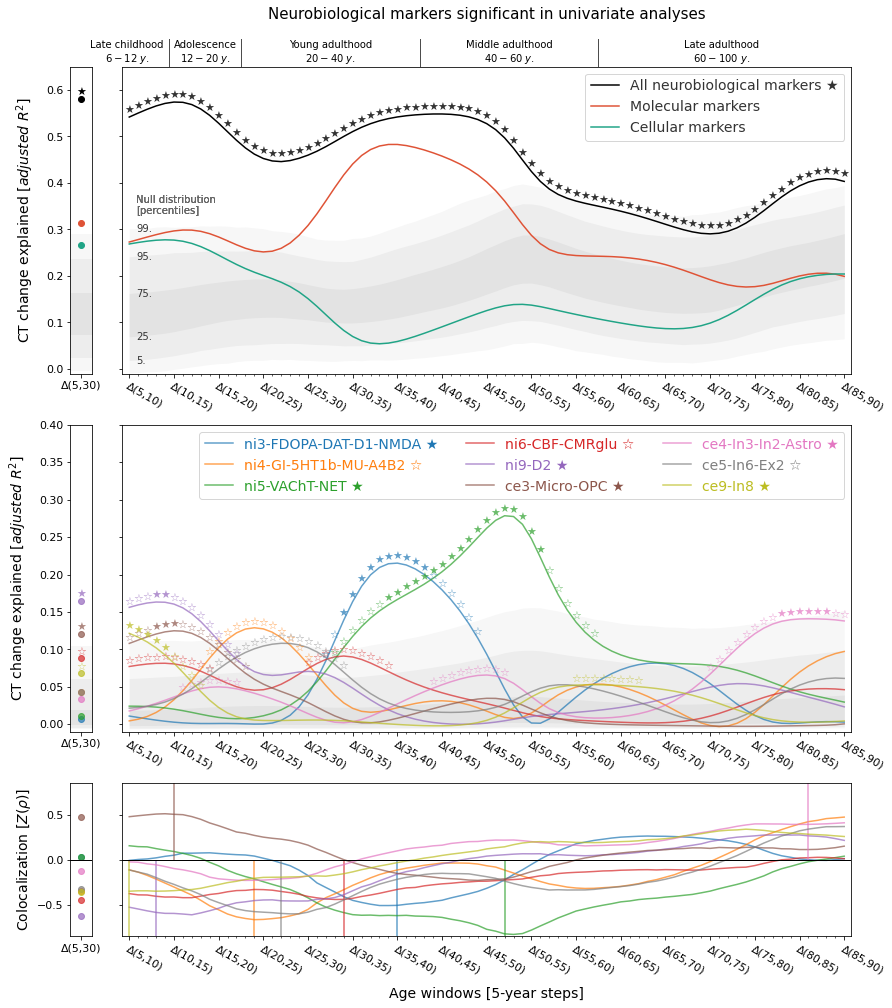

In [32]:
fig, axes = plt.subplots(3,2, figsize=(14,16), sharey="row", #constrained_layout=True,
                        gridspec_kw=dict(width_ratios=(0.03,1), 
                                         height_ratios=(1,1,0.5),
                                         wspace=0.08))
fig.patch.set_facecolor('w')
    
## dominance analysis
# all 
plot_diffs(
    plot_pred=False,
    data=juspyce_ct_dominance.predictions["dominance_total"], 
    data_p=None,
    data_total=juspyce_ct_dominance.predictions["dominance_full_r2"],
    data_total_p=p_to_ast(juspyce_ct_dominance.p_predictions["dominance_full_r2"], 
                          juspyce_ct_dominance.p_predictions["dominance_full_r2--fdr_bh"]), 
    data_null=pd.DataFrame(
        np.c_[[juspyce_ct_dominance.nulls["predictions-dominance"][i]["dominance_full_r2"][:,0] \
            for i in range(n_perm)]],
        index=range(n_perm),
        columns=tps_index
    ),
    annotate_pctl=True,
    axes=[axes[0,0], axes[0,1]],
    legend_color="0.2",
    legend_size=14,
    total_color=["#DF5336", "#20A486"]
)
# single
plot_diffs(
    plot_pred=True,
    data=juspyce_ct_dominance.predictions["dominance_total"],
    data_p=p_to_ast(juspyce_ct_dominance.p_predictions["dominance_total"], 
                    juspyce_ct_dominance.p_predictions["dominance_total--fdr_bh"]),
    data_total=None, 
    data_total_p=None,
    data_null=pd.DataFrame(
        data=np.column_stack([juspyce_ct_dominance.nulls["predictions-dominance"][i]["dominance_total"] \
            for i in range(n_perm)]).T,
        index=range(n_perm*len(predictors_sig)),
        columns=tps_index
    ),
    axes=[axes[1,0], axes[1,1]],
    legend_size=14
)
# age stages
add_stages(axes[0,1])

# spearman correlations
max_pred = juspyce_ct_dominance.predictions["dominance_total"].iloc[1:,:].idxmax()
sig_correlations = juspyce_ct_dominance.predictions["spearman"]
colors = get_cmap("tab10")(range(len(predictors_sig)))
ax1, ax2 = axes[2,0], axes[2,1]
for i, p in enumerate(predictors_sig):
    ax1.scatter(0, sig_correlations[p][0], color=colors[i], alpha=0.7)
    ax2.plot(list(sig_correlations.index[1:]), 
             sig_correlations[p][1:], 
             color=colors[i], alpha=0.7, label=p)
    ax2.plot([max_pred.loc[predictors_sig][i],
              max_pred.loc[predictors_sig][i]], 
             [0,1 if sig_correlations.loc[max_pred.loc[predictors_sig][i],p]>0 else -1], 
             c=colors[i], linewidth=1.5, alpha=0.7, solid_capstyle="butt")
# left
ax1.axhline(0, c="k", linewidth=1)
ax1.set_xticks(axes[1,0].get_xticks())
ax1.set_xlim(axes[1,0].get_xlim())
#ax1.set_xticklabels([tps_index[0]], rotation=-30, ha="left", rotation_mode="anchor")
ax1.set_xticklabels([tps_index[0]])
ax1.tick_params(axis="both", which="major", labelsize=11)
# right
ax2.axhline(0, c="k", linewidth=1)
ax2.set_xticks(axes[1,1].get_xticks())
ax2.set_xticks(axes[1,1].get_xticks(minor=True), minor=True)
ax2.set_xticklabels(tps_index[1::5] + [""], rotation=-30, ha="left", rotation_mode="anchor")
ax2.set_xlim(axes[1,1].get_xlim())
ax2.tick_params(axis="both", which="major", labelsize=11)

# finish
axes[0,0].set_ylim(-0.01, 0.65)
axes[1,0].set_ylim(-0.01, 0.4)
axes[2,0].set_ylim(-0.85,0.85)
[axes[i,0].set_ylabel("CT change explained [$adjusted\ R^2$]", size=14, labelpad=10) for i in [0,1]]
axes[2,0].set_ylabel("Colocalization "+r"[$Z (\rho)$]", size=14)
axes[2,1].set_xlabel("Age windows [5-year steps]", size=14, labelpad=11)
axes[0,1].set_title("Neurobiological markers significant in univariate analyses", size=15, pad=20)
fig.savefig(join(plot_dir_dom, f'dev_ct_dominance_fm_500_5.pdf'),  bbox_inches='tight')
plt.show()

#### Plot single dominance

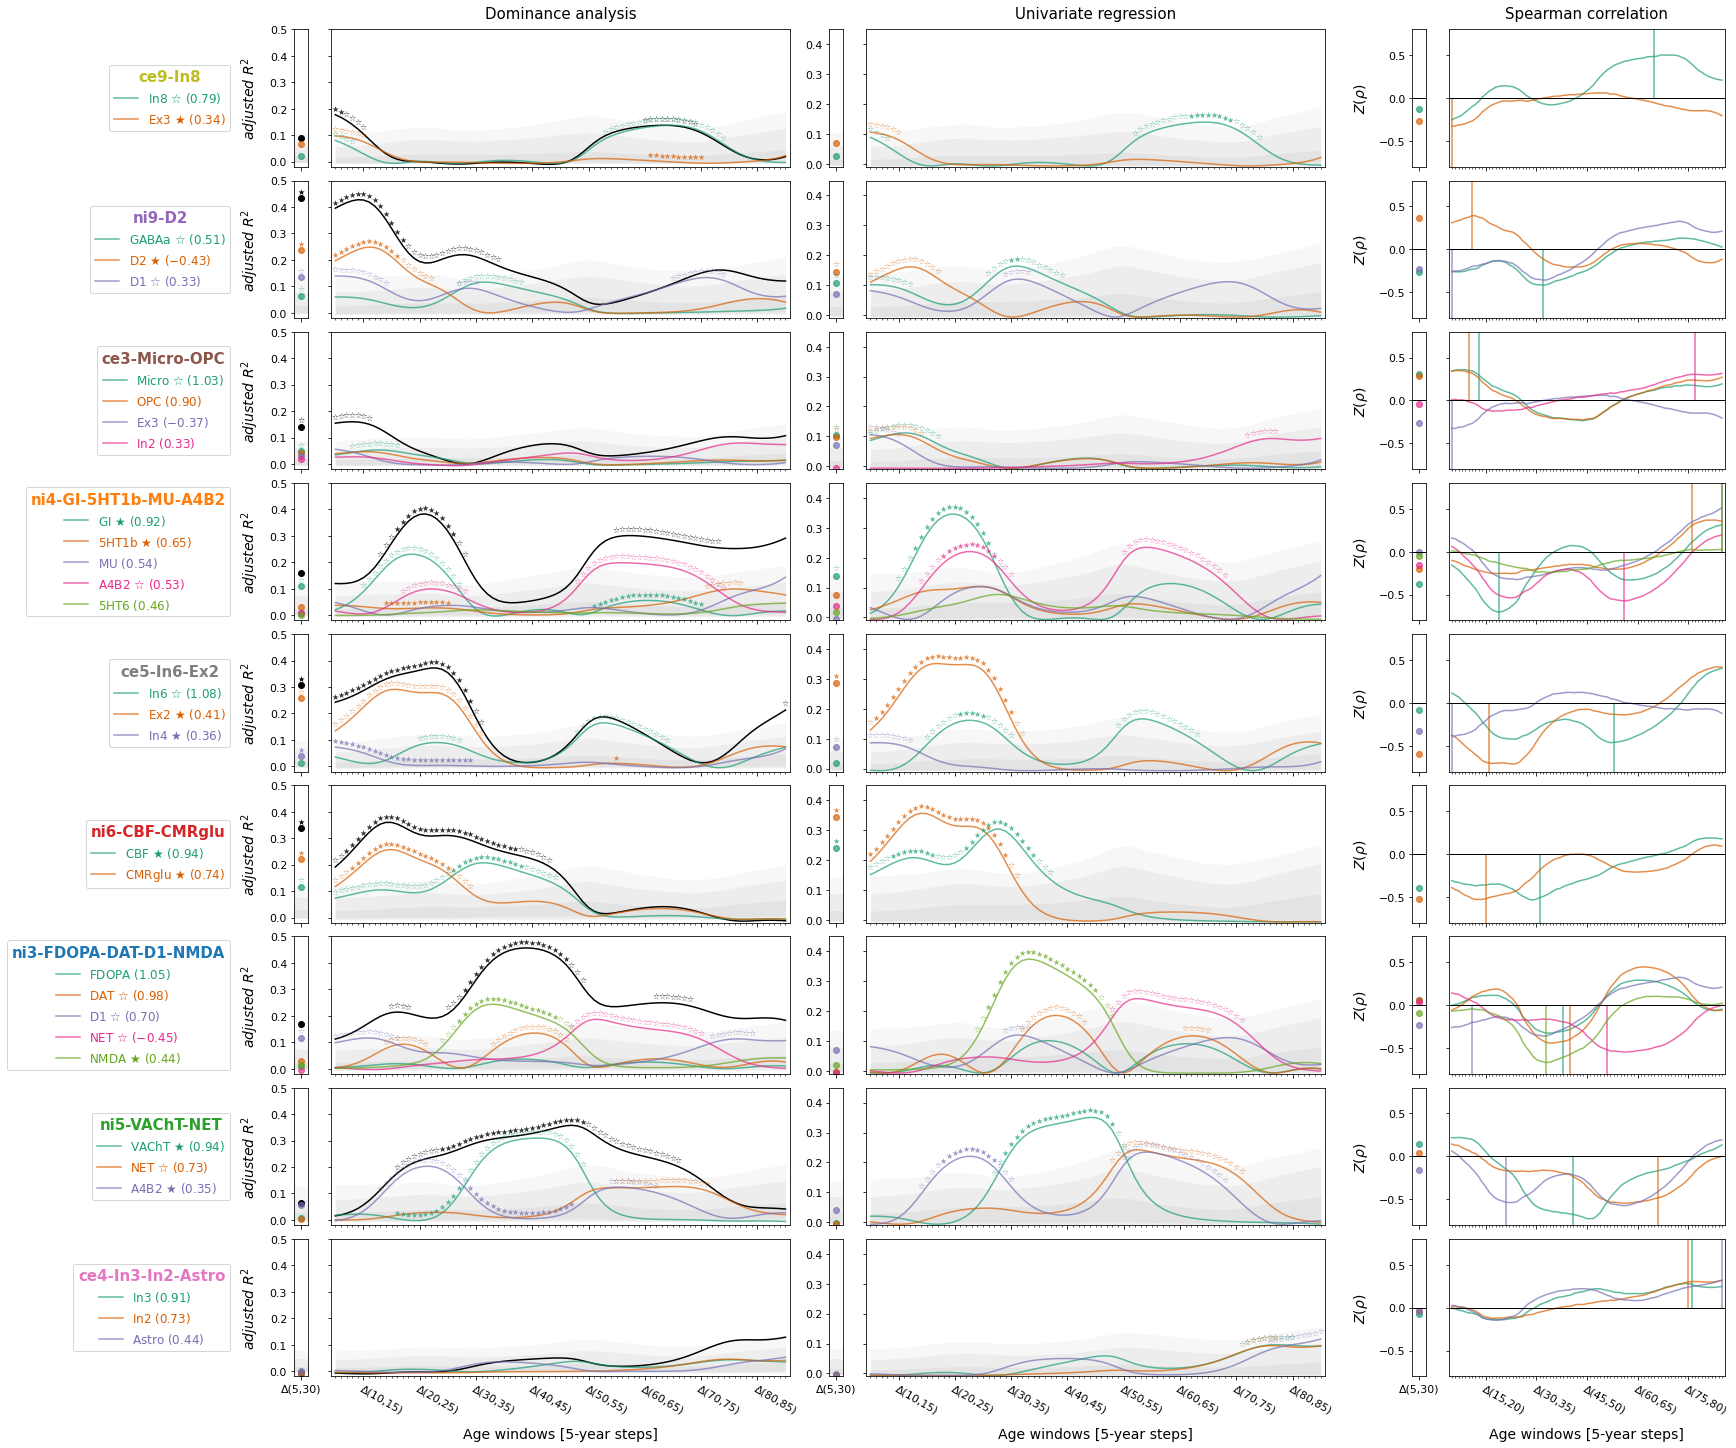

In [228]:
fig, axes = plt.subplots(len(predictors_sig), 6, figsize=(24,20), # (24,13)
                         constrained_layout=True, sharex="col", sharey="col",
                         gridspec_kw=dict(width_ratios=(0.03,1, 0.03,1, 0.03,0.6)))
fig.patch.set_facecolor('w')
colors = get_cmap("tab10")(range(len(predictors_sig)))
#colors_single = ["darkcyan", "brown", "darkgoldenrod", ""]
colors_single = get_cmap("Dark2")(range(10))

# get time period of maximum explained variance for each predictor
max_pred = juspyce_ct_dominance.predictions["dominance_total"].iloc[1:,:].idxmax()
max_pred_i = np.argsort([int(max_pred[i].replace("Δ(","").split(",")[0]) for i in range(len(max_pred))])
max_pred_ordered = max_pred.iloc[max_pred_i]

# iterate predictors
for r, pred in enumerate(max_pred_ordered.index):
    
    # original predictors
    pred_original = predictors_sig_loadings[pred]["predictors"]
     
    # original predictor-wise dominance
    plot_diffs(
        plot_pred=True,
        plot_subsystems=False,
        data=juspyce_ct_dominance_single[pred].predictions["dominance_total"], 
        data_p=p_to_ast(juspyce_ct_dominance_single[pred].p_predictions["dominance_total"], 
                        juspyce_ct_dominance_single[pred].p_predictions["dominance_total--fdr_bh_all"]), 
        data_total=juspyce_ct_dominance_single[pred].predictions["dominance_full_r2"],
        data_total_p=p_to_ast(juspyce_ct_dominance_single[pred].p_predictions["dominance_full_r2"], 
                              juspyce_ct_dominance_single[pred].p_predictions["dominance_full_r2--fdr_bh_all"]), 
        data_null=pd.DataFrame(
            data=np.column_stack(
                [juspyce_ct_dominance_single[pred].nulls["predictions-dominance"][i]["dominance_total"] \
                    for i in range(n_perm)]
            ).T,
            index=range(n_perm*len(pred_original)),
            columns=tps_index
        ),
        axes=[axes[r,0], axes[r,1]],
        pos_text=[-0.02,0.04],
        size_text=8,
        title=pred,
        title_size=15,
        title_color=colors[max_pred_i[r]],
        colors=colors_single,
    )
    
    # univariate regression
    plot_diffs(
        plot_pred=True,
        data=juspyce_ct_dominance_single[pred].predictions["dominance_individual"], 
        data_p=p_to_ast(juspyce_ct_dominance_single[pred].p_predictions["dominance_individual"], 
                        juspyce_ct_dominance_single[pred].p_predictions["dominance_individual--fdr_bh_all"]), 
        data_total=None,
        data_total_p=None, 
        data_null=pd.DataFrame(
            data=np.column_stack(
                [juspyce_ct_dominance_single[pred].nulls["predictions-dominance"][i]["dominance_individual"] \
                    for i in range(n_perm)]
            ).T,
            index=range(n_perm*len(pred_original)),
            columns=tps_index
        ),
        axes=[axes[r,2], axes[r,3]],
        pos_text=[-0.02,0.04],
        size_text=8,
        title=pred,
        title_size=15,
        title_color=colors[max_pred_i[r]],
        colors=colors_single,
        legend=False
    )
    
    # spearman correlations
    predictors_spearman = pred_original
    max_pred = juspyce_ct_dominance_single[pred].predictions["dominance_total"].iloc[1:,:].idxmax()
    correlations = juspyce_ct_dominance_single[pred].predictions["spearman"]
    ax1, ax2 = axes[r,4], axes[r,5]
    for i, p in enumerate(predictors_spearman):
        ax1.scatter(0, correlations[p][0], color=colors_single[i], alpha=0.7)
        ax2.plot(list(correlations.index[1:]), 
                 correlations[p][1:], 
                 color=colors_single[i], alpha=0.7, label=p)
        ax2.plot([max_pred.loc[predictors_spearman][i],
                 max_pred.loc[predictors_spearman][i]], 
                 [0,1 if correlations.loc[max_pred.loc[predictors_spearman][i],p]>0 else -1], 
                 c=colors_single[i], linewidth=1.5, alpha=0.7, solid_capstyle="butt")
    ax1.axhline(0, c="k", linewidth=1)
    ax2.axhline(0, c="k", linewidth=1)
    
    # legend
    handles, labels = axes[r,1].get_legend_handles_labels()
    handles, labels = handles[1:], labels[1:]
    labels = [f"{l} $({predictors_sig_loadings[pred]['loadings'][i]:.02f})$" \
        for i, l in enumerate(labels)]
    legend = axes[r,0].legend(
        handles, labels,
        loc="center right", 
        bbox_to_anchor=(-4.2, 0.5), 
        prop=dict(size=12),
        labelcolor="linecolor"
    )
    legend.set_title(pred)
    plt.setp(legend.get_title(), color=colors[max_pred_i[r]], size=15, weight="semibold")
    axes[r,1].legend().remove()
    
    ## layout         
    # dominance
    [axes[r,i].set_ylim(-0.02, 0.5) for i in [0,1]]
    # left
    axes[r,0].set_ylabel("$adjusted\ R^2$", size=14, labelpad=9)
    # right
    axes[r,1].set_yticklabels("")
    axes[r,1].set_yticklabels("")
    axes[r,1].set_xticks(list(np.arange(5,80,10)))
    axes[r,1].set_xticks(list(range(81)), minor=True)
    
    # SLR
    [axes[r,i].set_ylim(-0.01, 0.45) for i in [2,3]]
    # right
    axes[r,3].set_yticklabels("")
    axes[r,3].set_xticks(list(np.arange(5,80,10)))
    axes[r,3].set_xticks(list(range(81)), minor=True)
    
    # spearman
    [axes[r,i].set_ylim(-0.8, 0.8) for i in [4,5]]
    # left
    axes[r,4].set_ylabel("\n"+r"$Z(\rho)$", size=14, labelpad=9)
    axes[r,4].set_xticks(axes[r,0].get_xticks())
    axes[r,4].set_xticklabels(axes[r,0].get_xticklabels())
    #axes[r,4].set_xticklabels([tps_index[0]], rotation=-30, ha="left", rotation_mode="anchor")
    axes[r,4].tick_params(axis="both", which="major", labelsize=11)
    # # right
    axes[r,5].set_yticklabels("")
    axes[r,5].set_xlim(-0.8, correlations.shape[0]-1.2)
    axes[r,5].set_xticks(list(np.arange(10,80,15)))
    axes[r,5].set_xticks(list(range(81)), minor=True)
    axes[r,5].set_xticklabels(tps_index[11::15], rotation=-30, ha="left", rotation_mode="anchor")
    axes[r,5].tick_params(axis="both", which="major", labelsize=11)

axes[0,1].set_title("Dominance analysis", size=15, pad=11)
axes[0,3].set_title("Univariate regression", size=15, pad=11)
axes[0,5].set_title("Spearman correlation", size=15, pad=11)

[axes[len(predictors_sig)-1,i].set_xlabel("Age windows [5-year steps]", size=14, labelpad=11) \
    for i in [1,3,5]]

fig.savefig(join(plot_dir_dom, f'dev_ct_dominance_single_fm_500_5.pdf'), bbox_inches="tight")

#### Plot correlations & brains

##### Plot functions

In [15]:
# predictor plot
def plot_pred(pred, delta, pe, axes, title="", lab1="", lab2="", lab3="", c="k", cmap="viridis", 
              title_size=13, title_x=-0.35, r=True, cmap_orientation="vertical"):
    # limits
    lims_pe = (-np.abs(pe).max(), np.abs(pe).max())
    lims_delta = (-np.abs(delta).max(), np.abs(delta).max())
    # scatter
    sns.scatterplot(x=pred, y=delta, ax=axes[0], 
                    hue=pe, palette="RdBu_r", legend=None, 
                    alpha=0.7, hue_norm=lims_pe, edgecolor='k')
    sns.regplot(x=pred, y=delta, ax=axes[0], 
                color=c, scatter=False, truncate=False)
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")
    r = corr(pred, delta, "rows", True)
    if r:
        axes[0].annotate(
            text=f"${r:.2f}$",
            xy=(0.05,0.82) if r>0 else (0.95,0.82),
            xycoords="axes fraction",
            ha="left" if r>0 else "right",
            c=c,
            bbox=dict(boxstyle="round,pad=0.15", fc="white", alpha=0.5)
        )
    # pe brain
    plot_surf_ax(lh=get_parc_gifti(pe)[0], fig=fig, ax=axes[1], c="RdBu_r", size=(1000,400), 
                 cbar=True, c_lims=lims_pe, cbar_orientation=cmap_orientation, 
                 rotate_labels=True if cmap_orientation=="horizontal" else False)
    # delta brain
    plot_surf_ax(lh=get_parc_gifti(delta)[0], fig=fig, ax=axes[2], c="RdBu_r", size=(1000,400), 
                 cbar=True, c_lims=lims_delta, cbar_orientation=cmap_orientation)
    # pred brain
    plot_surf_ax(lh=get_parc_gifti(pred)[0], fig=fig, ax=axes[3], c=cmap, size=(1000,400), 
                 cbar=True, cbar_symm=False, cbar_orientation=cmap_orientation)
    # labels
    #axes[0].set_title(title, loc="left", ha="left", size=title_size, weight="semibold", c=c)
    if title!="":
        axes[0].annotate(title, xy=(title_x, 0.5), xycoords="axes fraction", ha="right", va="center",  
                         size=title_size, c=c, weight="semibold")
    axes[1].annotate(lab1, xy=(0.5,-0.2), xycoords="axes fraction", size=12, c=c, ha="center")
    axes[2].annotate(lab2, xy=(0.5,-0.2), xycoords="axes fraction", size=12, c=c, ha="center")
    axes[3].annotate(lab3, xy=(0.5,-0.2), xycoords="axes fraction", size=12, c=c, ha="center")

##### Factor-level

ce9-In8
ni9-D2
ce3-Micro-OPC
ni4-GI-5HT1b-MU-A4B2
ce5-In6-Ex2
ni6-CBF-CMRglu
ni3-FDOPA-DAT-D1-NMDA
ni5-VAChT-NET
ce4-In3-In2-Astro


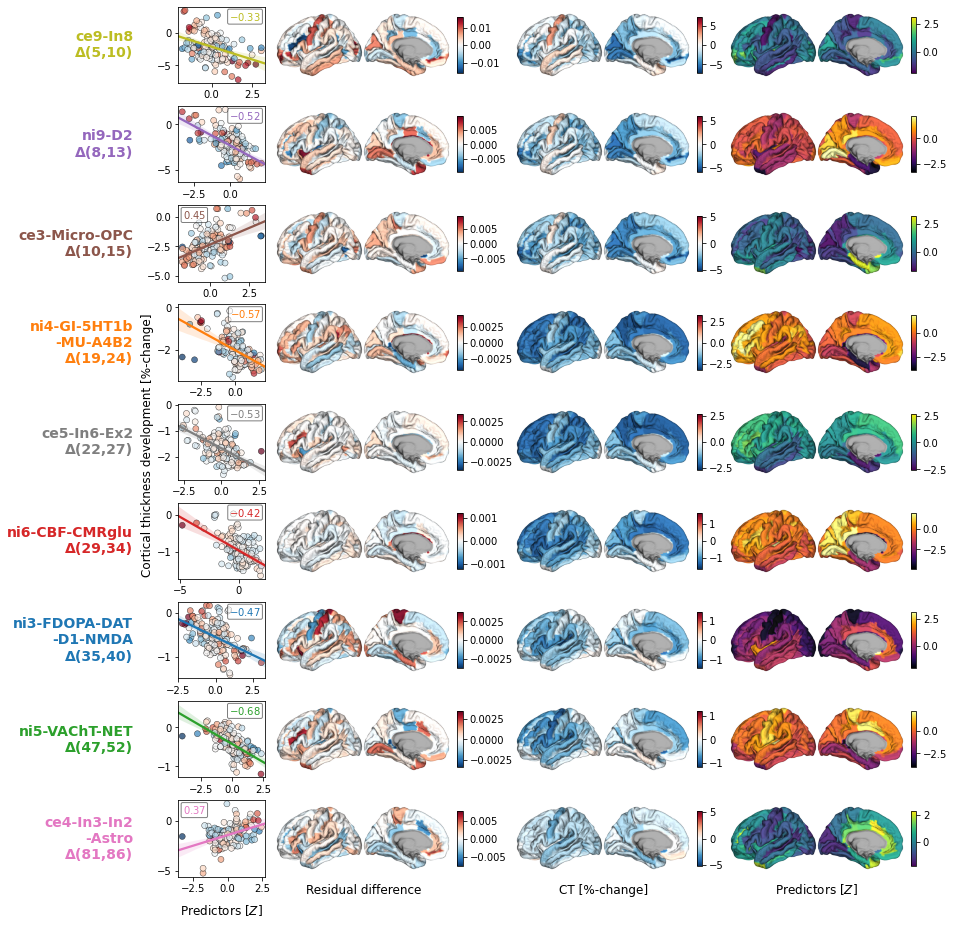

In [16]:
fig, axes = plt.subplots(len(predictors_sig), 6, figsize=(13,16),
                         gridspec_kw=dict(width_ratios=(0.5, 1, 0.25, 1, 0.1, 1),
                                          wspace=0.1,
                                          hspace=0.3))
colors = get_cmap("tab10")(range(len(predictors_sig)))

for r, pred in enumerate(max_pred_ordered.index[:]):
    print(pred)
    
    # color
    if pred.startswith("ni"): cmap = "inferno"
    elif pred.startswith("ce"): cmap = "viridis"
    else: cmap = "cividis"
    
    # plot factor
    plot_pred(
        pred=juspyce_ct_dominance.X.loc[pred,:],
        delta=juspyce_ct_dominance.Y.loc[max_pred_ordered[r],:] * 100,
        pe=regional_influence[max_pred_ordered[r]][pred],
        axes=[axes[r,0], axes[r,1], axes[r,3], axes[r,5]],
        title= \
            ("-".join(pred.split("-")[:3]) + "\n-" + "-".join(pred.split("-")[3:]) \
                if len(pred.split("-")) > 3 else pred) + \
                f"\n{max_pred_ordered[r]}",
        c=colors[max_pred_i[r]],
        title_size=14,
        title_x=-0.52,
        cmap=cmap
    )

[axes[-1,c].annotate(l, xy=(0.5,pad), xycoords="axes fraction", size=12, ha="center") \
    for c,l,pad in zip(
        [0,1,3,5], 
        ["Predictors [$Z$]", "Residual difference", "CT [%-change]", "Predictors [$Z$]"],
        [-0.5,-0.3,-0.3,-0.3])]

hide_empty_axes(axes)

fig.supylabel("Cortical thickness development [%-change]", size=12, x=0.085)

# save and show plot
fig.savefig(join(plot_dir_dom, 'dev_ct_corbrains_fm_500_5.png'), bbox_inches="tight", dpi=250)
plt.show()

##### Original predictor-level

ce9-In8
In8
Ex3
ni9-D2
GABAa
D2


Context leak detected, msgtracer returned -1


D1
ce3-Micro-OPC
Micro
OPC
Ex3
In2
ni4-GI-5HT1b-MU-A4B2
GI
5HT1b
MU
A4B2


Context leak detected, msgtracer returned -1


5HT6
ce5-In6-Ex2
In6
Ex2
In4
ni6-CBF-CMRglu
CBF
CMRglu
ni3-FDOPA-DAT-D1-NMDA
FDOPA
DAT


Context leak detected, msgtracer returned -1


D1
NET
NMDA
ni5-VAChT-NET
VAChT
NET
A4B2
ce4-In3-In2-Astro
In3
In2


Context leak detected, msgtracer returned -1


Astro


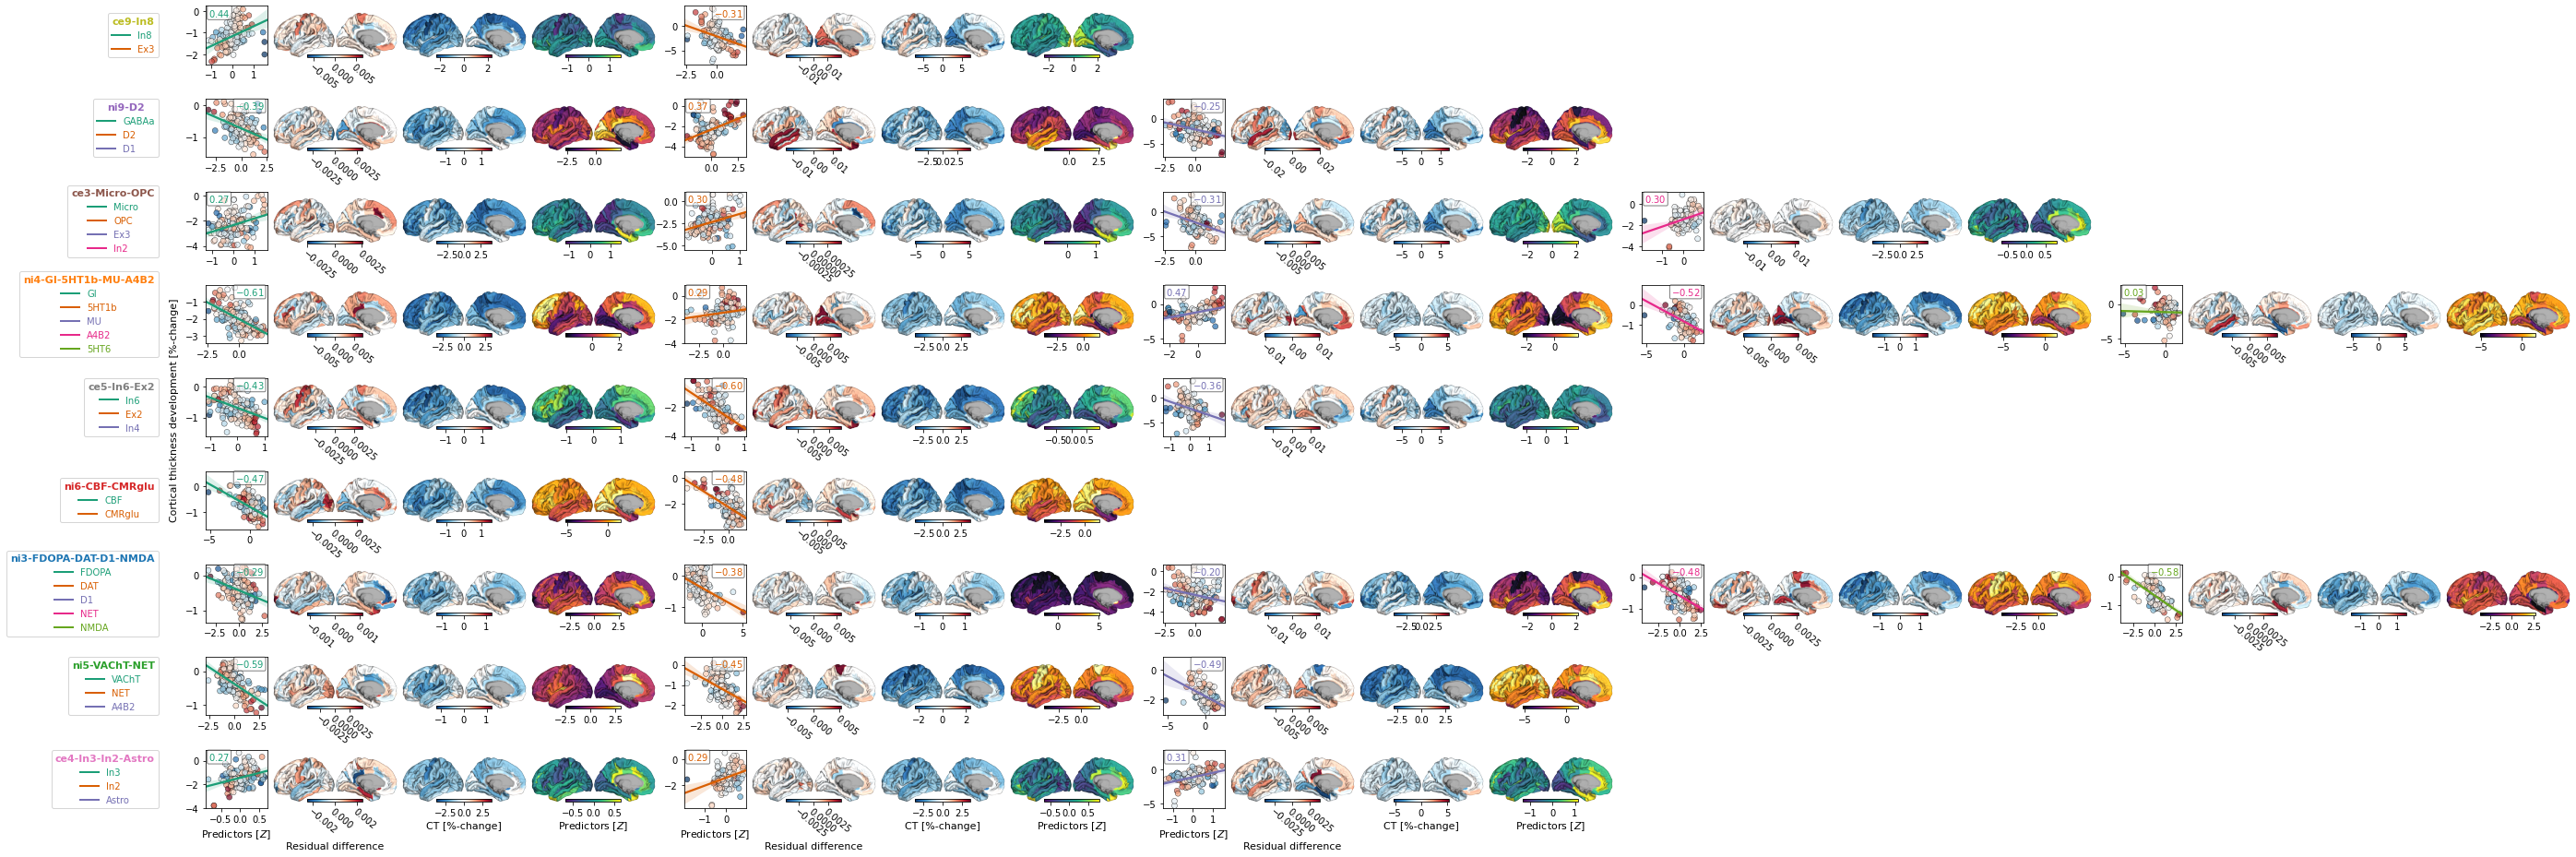

In [28]:
fig, axes = plt.subplots(len(predictors_sig), 5*4+5, figsize=(47,16),
                         gridspec_kw=dict(width_ratios=[0.4, 0.5,1,1,1] + [0.15, 0.5,1,1,1]*4,
                                          wspace=0.06,
                                          hspace=0.6))
colors = get_cmap("tab10")(range(10))
colors_single = get_cmap("Dark2")(range(10))

max_pred = juspyce_ct_dominance.predictions["dominance_total"].iloc[1:,:].idxmax()
max_pred_i = np.argsort([int(max_pred[i].replace("Δ(","").split(",")[0]) for i in range(len(max_pred))])
max_pred_ordered = max_pred.iloc[max_pred_i]

for r, pred in enumerate(max_pred_ordered.index[:]):
    print(pred)
    
    # original predictors
    pred_original = predictors_sig_loadings[pred]["predictors"]
    
    # legend
    axes[r,0].axis("off")
    legend = axes[r,0].legend(
        [Line2D([0], [0], color=colors_single[i], lw=2) for i in range(len(pred_original))],
        pred_original, 
        loc="center right", 
        bbox_to_anchor=(0.25, 0.5), 
        prop=dict(size=10),
        labelcolor="linecolor")
    legend.set_title(pred)
    plt.setp(legend.get_title(), color=colors[max_pred_i[r]], size=11, weight="semibold")
    
    # colormaps
    if pred.startswith("ni"): cmap = "inferno"
    elif pred.startswith("ce"): cmap = "viridis"
    else: cmap = "cividis"
    
    max_pred_original = \
        juspyce_ct_dominance_single[pred].predictions["dominance_total"].iloc[1:,:].idxmax()

    c=1
    for i, pred_original in enumerate(pred_original):
        print(pred_original)
        # original predictor
        plot_pred(
            pred=juspyce_ct_dominance_single[pred].X.loc[pred_original,:],
            delta=juspyce_ct_dominance.Y.loc[max_pred_original[i],:] * 100,
            pe=regional_influence_single[pred][max_pred_original[i]][pred_original],
            axes=[axes[r,c], axes[r,c+1], axes[r,c+2], axes[r,c+3]],
            #title=f"{pred_original}: {max_pred_original[i]}",
            c=colors_single[i],
            #title_size=13,
            cmap=cmap,
            cmap_orientation="horizontal"
        )
        axes[r,c-1].axis("off")
        c += 5
    [axes[r,i].axis("off") for i in range(c-1, axes.shape[1])]
    
for c in [1,6,11]:
    for cc,l,pad in zip(
        range(4),
        ["Predictors [$Z$]", "Residual difference", "CT [%-change]", "Predictors [$Z$]"],
        [-0.5,-0.9,-0.5,-0.5]
    ):
        axes[-1,c+cc].annotate(l, xy=(0.5,pad), xycoords="axes fraction", size=11, ha="center")

fig.supylabel("Cortical thickness development [%-change]", size=11, x=0.131)

fig.savefig(join(plot_dir_dom, 'dev_ct_corbrains_single_fm_500_5.png'),  bbox_inches='tight', dpi=250)
plt.show()

#### Plot all regional influence

0 Δ(5,10)
1 Δ(10,15)
2 Δ(15,20)


Context leak detected, msgtracer returned -1


3 Δ(20,25)
4 Δ(30,35)
5 Δ(40,45)


Context leak detected, msgtracer returned -1


6 Δ(50,55)
7 Δ(60,65)


Context leak detected, msgtracer returned -1


8 Δ(70,75)
9 Δ(80,85)


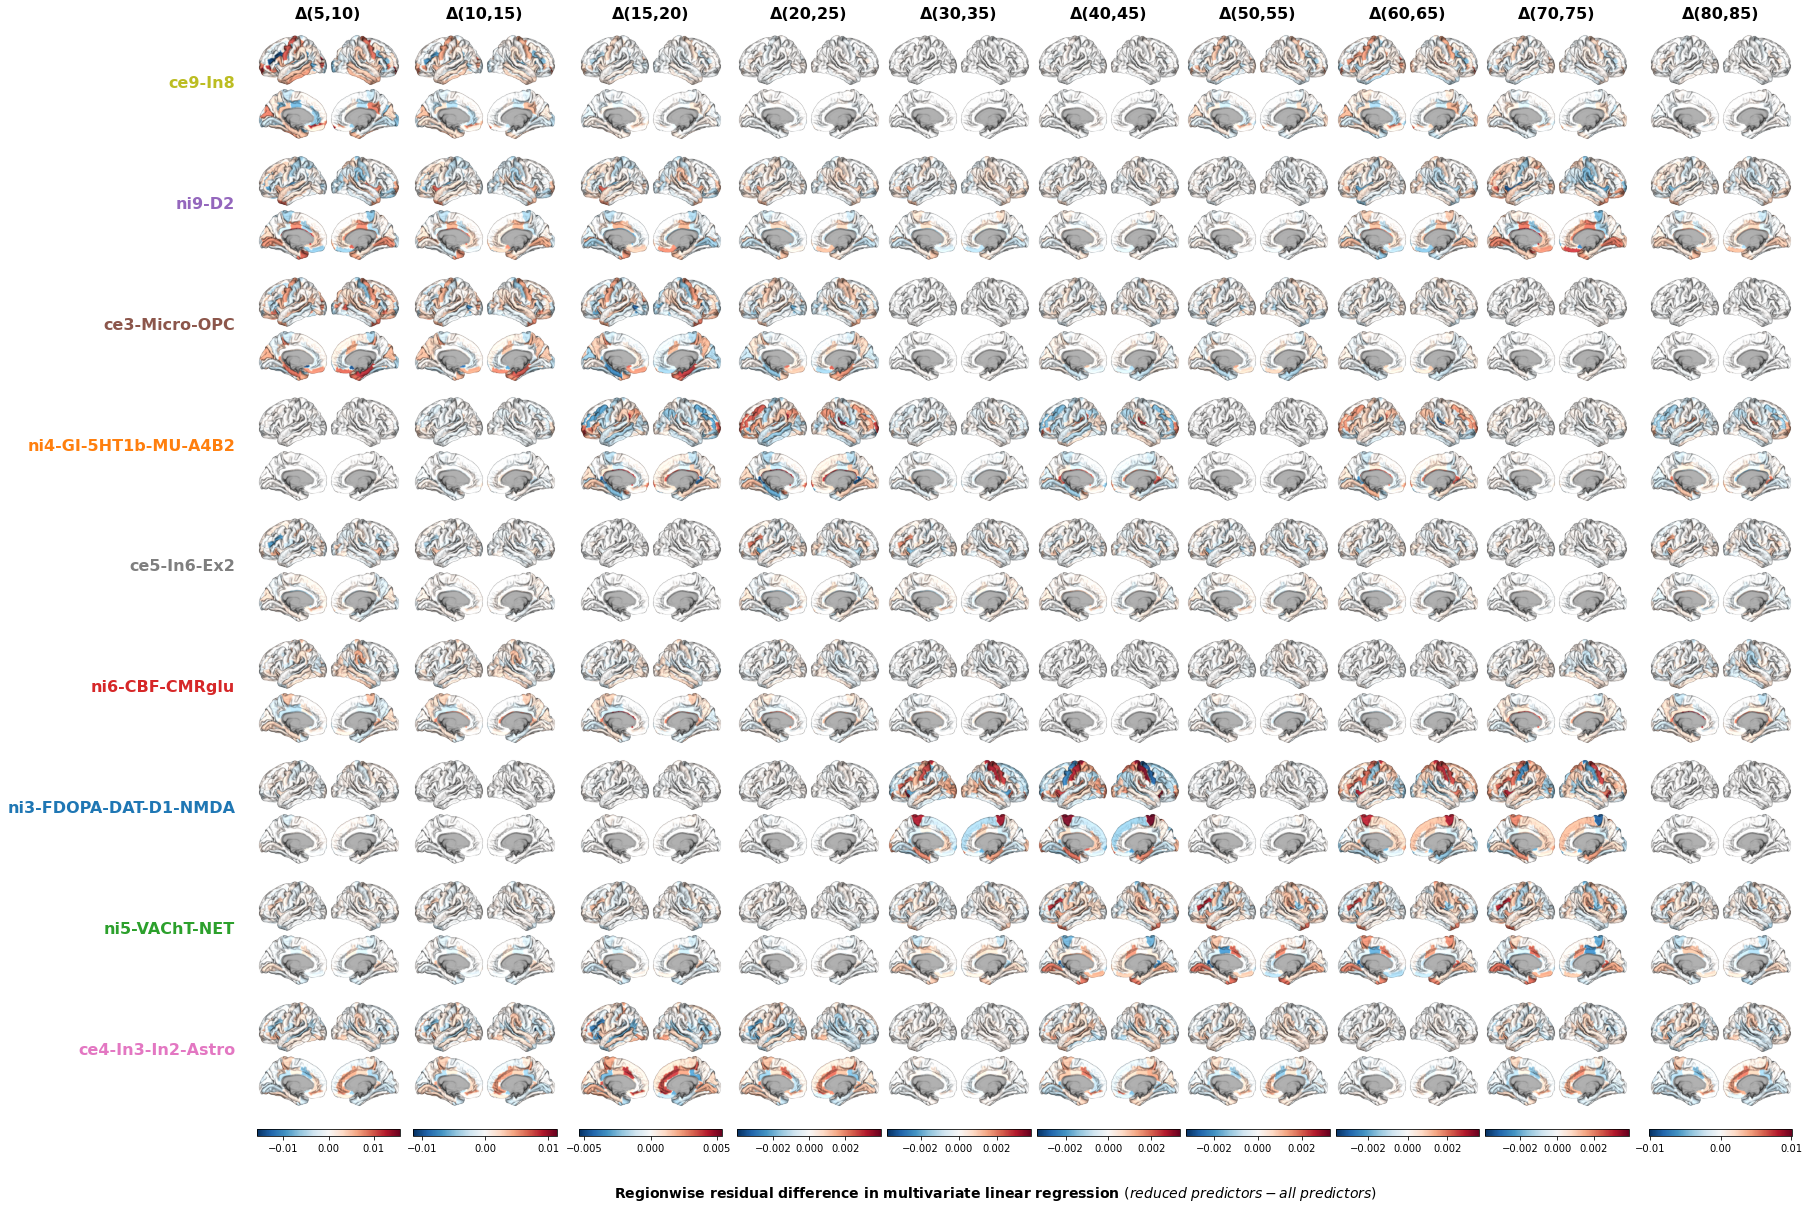

In [29]:
# time points
tps_plot = [tps_index[i+1] for i in [0,5,10,15,25,35,45,55,65,75]]
# colors
colors = get_cmap("tab10")(range(len(predictors_sig)))
# sort predictors
max_pred = juspyce_ct_dominance.predictions["dominance_total"].iloc[1:,:].idxmax()
max_pred_i = np.argsort([int(max_pred[i].replace("Δ(","").split(",")[0]) for i in range(len(max_pred))])
max_pred_ordered = max_pred.iloc[max_pred_i]

# figure
fig, axes = plt.subplots(len(predictors_sig)+1, len(tps_plot), figsize=(25,16), 
                         constrained_layout=True,
                         gridspec_kw=dict(height_ratios=[1]*len(predictors_sig)+[0.1]))

# iterate time points/columns
for i_tp, tp in enumerate(tps_plot):
    print(i_tp, tp)
        
    # limit for cbar
    lim = np.abs(regional_influence[tp]).max().max()
    
    # plot
    # iterate predictors/rows
    for i_pred, pred in enumerate(max_pred_ordered.index):
        lh, rh = get_parc_gifti(regional_influence[tp][pred], parc_gifti=parc_destrieux)
        plot_surf_ax(
            lh=lh,
            rh=rh,
            ax=axes[i_pred,i_tp], 
            fig=fig, 
            c="RdBu_r", 
            c_lims=(-lim,lim),
            size=(1000,750),
            layout="grid", 
            zoom=1.65
        )
        
    # colorbar
    axes[len(predictors_sig),i_tp].axis("off")
    fig.colorbar(
        cm.ScalarMappable(
            norm=Normalize(-lim,lim), 
            cmap="RdBu_r"), 
        ax=axes[len(predictors_sig), i_tp],
        orientation="horizontal",
        fraction=1,
        pad=0)
    
# style
[axes[0,i].set_title(tp, size=16, weight="semibold", pad=15) for i, tp in enumerate(tps_plot)]
[axes[i,0].annotate(pred, (-0.15,0.5), xycoords="axes fraction", ha="right", size=16, 
                    weight="semibold", color=colors[max_pred_i[i]]) \
    for i, pred in enumerate(max_pred_ordered.index)]
fig.supxlabel("Regionwise residual difference in multivariate linear regression "
              "$(reduced\ predictors - all\ predictors)$",
              size=14, weight="semibold", y=-0.04, x=0.55)

fig.savefig(join(plot_dir_dom, 'dev_ct_regioninfluence_fm_500_5.png'),  bbox_inches="tight", dpi=250)